# Проверка результатов A/B теста

Вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей.  
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы.  
При этом стоимость пробного периода оставалась прежней.  

Проверьте:  
- был ли эксперимент успешен в целом?  
- проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей?

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Всего есть три группы:  
тестовая (test)  
контрольная 1 (control_1)  
контрольная 2 (control_2)  

Файлы:  
users_test – информация о пользователях в тестовой группе.   
users_control_1 – информация о пользователях в первой контрольной группе.   
users_control_2 – информация о пользователях во второй контрольной группе.  
transactions_test – информация о платежах пользователей в тестовой группе.  
transactions_control_1 – информация о платежах пользователей в первой контрольной группе.  
transactions_control_2 – информация о платежах пользователей во второй контрольной группе.  

### Данные:

users_*.csv – информация о пользователях:  

uid – идентификатор пользователя  
age – возраст  
attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры∗1000)  
coins – число монеток (внутренняя валюта)  
country – страна    
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
gender – пол  
age_filter_start  – фильтр поиска, мин. значение   
age_filter_end  – фильтр поиска, макс. значение   
views_count – число полученных оценок  
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  
is_premium –  является ли премиум  
total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:  

uid – идентификатор пользователя  
country – страна  
joined_at – дата и время регистрации  
paid_at – дата и время покупки  
revenue – нормированная выручка  
payment_id – идентификатор платежа  
from_page – откуда пользователь перешел на страницу оплаты  
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)  

In [3]:
import requests 
from urllib.parse import urlencode 

import pandas as pd
import numpy as np
import random

import scipy
import pingouin as pg

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (12,6.75)})

## Подготовим данные

In [4]:
# получение данных с ЯндексДиск по ссылке
def get_csv_from_yd(public_link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    return (pd.read_csv(download_url, sep=';'))

In [5]:
# читаем данные
users_test = get_csv_from_yd('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = get_csv_from_yd('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = get_csv_from_yd('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
transactions_test = get_csv_from_yd('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = get_csv_from_yd('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = get_csv_from_yd('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

In [6]:
# смотрим users_test
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [7]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [8]:
# поправим тип данных, заполним пропуски
users_test['country'] = users_test.country.astype('string')
users_test['coins'] = users_test.coins.fillna(0).astype('int64')
users_test['was_premium'] = users_test.was_premium.fillna(0).astype('int64')
users_test['is_premium'] = users_test.is_premium.fillna(0).astype('int64')

In [9]:
# дубликаты
users_test.duplicated().sum()

0

In [10]:
# смотрим users_control_1
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [11]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [12]:
# устраним недостатки данных аналогичным методом
users_control_1['country'] = users_control_1.country.astype('string')
users_control_1['coins'] = users_control_1.coins.fillna(0).astype('int64')
users_control_1['was_premium'] = users_control_1.was_premium.fillna(0).astype('int64')
users_control_1['is_premium'] = users_control_1.is_premium.fillna(0).astype('int64')

In [13]:
# дубликаты
users_control_1.duplicated().sum()

0

In [14]:
# смотрим users_control_2
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [15]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [16]:
# устраним недостатки данных аналогичным методом
users_control_2['country'] = users_control_2.country.astype('string')
users_control_2['coins'] = users_control_2.coins.fillna(0).astype('int64')
users_control_2['was_premium'] = users_control_2.was_premium.fillna(0).astype('int64')
users_control_2['is_premium'] = users_control_2.is_premium.fillna(0).astype('int64')

In [17]:
# дубликаты
users_control_2.duplicated().sum()

0

In [18]:
# смотрим transactions_test
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [19]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [20]:
# Поправим данные, приведём к соответствующему типу
transactions_test['country'] = transactions_test.country.astype('string')
transactions_test['joined_at'] = transactions_test.joined_at.astype('datetime64[ns]')
transactions_test['paid_at'] = transactions_test.paid_at.astype('datetime64[ns]')
transactions_test['from_page'] = transactions_test.from_page.astype('string')
transactions_test['product_type'] = transactions_test.product_type.astype('string')

In [21]:
# дубликаты
transactions_test.duplicated().sum()

7

In [22]:
# удалим дубликаты
transactions_test.drop_duplicates(inplace=True)

In [23]:
# смотрим transactions_control_1
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [24]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [25]:
# какие-то пустые строки
transactions_control_1[transactions_control_1.uid.isna()].head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
377,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
378,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
379,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
380,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
381,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [26]:
# удалим это
transactions_control_1.dropna(subset=['uid'],axis=0, inplace=True)

In [27]:
# Поправим данные, приведём к соответствующему типу
transactions_control_1['uid'] = transactions_control_1.uid.astype('int64')
transactions_control_1['country'] = transactions_control_1.country.astype('string')
transactions_control_1['joined_at'] = transactions_control_1.joined_at.astype('datetime64[ns]')
transactions_control_1['paid_at'] = transactions_control_1.paid_at.astype('datetime64[ns]')
transactions_control_1['revenue'] = transactions_control_1.revenue.astype('int64')
transactions_control_1['payment_id'] = transactions_control_1.payment_id.astype('int64')
transactions_control_1['from_page'] = transactions_control_1.from_page.astype('string')
transactions_control_1['product_type'] = transactions_control_1.product_type.astype('string')

In [28]:
# дубликаты
transactions_control_1.duplicated().sum()

21

In [29]:
# удалим дубликаты
transactions_control_1.drop_duplicates(inplace=True)

In [30]:
# смотрим transactions_control_2
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [31]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [32]:
# Поправим данные, приведём к соответствующему типу
transactions_control_2['country'] = transactions_control_2.country.astype('string')
transactions_control_2['joined_at'] = transactions_control_2.joined_at.astype('datetime64[ns]')
transactions_control_2['paid_at'] = transactions_control_2.paid_at.astype('datetime64[ns]')
transactions_control_2['from_page'] = transactions_control_2.from_page.astype('string')
transactions_control_2['product_type'] = transactions_control_2.product_type.astype('string')

In [33]:
# дубликаты
transactions_control_2.duplicated().sum()

5

In [34]:
# удалим дубликаты
transactions_control_2.drop_duplicates(inplace=True)

### Вывод:
- дубликаты в transactions_test (7 bp 273), transactions_control_1 (21 из 377), transactions_control_2 (5 из 328)
- много пропущеных данных в transactions_control_1 (из 1007)
- данные с ошибкой в дате transactions_control_1(3)
- типы данных скорректированы

## Присмотримся к данным

In [35]:
# проверим что все uid из transactions_test имеются в users_test
set(transactions_test.uid.unique()).issubset(users_test.uid.unique())

True

In [36]:
# проверим что все uid из transactions_control_1 имеются в users_control_1
set(transactions_control_1.uid.unique()).issubset(users_control_1.uid.unique())

True

In [37]:
# проверим что все uid из transactions_control_2 имеются в users_control_2
set(transactions_control_2.uid.unique()).issubset(users_control_2.uid.unique())

True

In [38]:
# диапазон дат joined_at для transactions_test
display(transactions_test.joined_at.min().strftime('%Y-%m-%d'),
transactions_test.joined_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-10-31'

In [39]:
# диапазон дат paid_at для transactions_test
display(transactions_test.paid_at.min().strftime('%Y-%m-%d'),
transactions_test.paid_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-12-11'

In [40]:
# какие-то сомнительные даты в transactions_control_1
date_error = transactions_control_1[transactions_control_1.joined_at < pd.to_datetime('2017-01-11')]
date_error

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


In [41]:
# удалим эти строки
transactions_control_1.drop(index=date_error.index.tolist(), inplace=True)

In [42]:
# диапазон дат joined_at для transactions_control_1
display(transactions_control_1.joined_at.min().strftime('%Y-%m-%d'),
transactions_control_1.joined_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-10-31'

In [43]:
# диапазон дат paid_at для transactions_control_1
display(transactions_control_1.paid_at.min().strftime('%Y-%m-%d'),
transactions_control_1.paid_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-12-11'

In [44]:
# диапазон дат joined_at для transactions_control_2
display(transactions_control_2.joined_at.min().strftime('%Y-%m-%d'),
transactions_control_2.joined_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-10-31'

In [45]:
# диапазон дат paid_at для transactions_control_2
display(transactions_control_2.paid_at.min().strftime('%Y-%m-%d'),
transactions_control_2.paid_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-12-11'

In [46]:
# смотрим долю строк с уникальным uid transactions_test
uniq_uid = transactions_test.uid.nunique()
all_rows = len(transactions_test)
uniq_uid, all_rows, round(uniq_uid/all_rows, 2)

(146, 266, 0.55)

In [47]:
# смотрим долю строк с уникальным uid transactions_control_1
uniq_uid = transactions_control_1.uid.nunique()
all_rows = len(transactions_control_1)
uniq_uid, all_rows, round(uniq_uid/all_rows, 2)

(192, 353, 0.54)

In [48]:
# смотрим долю строк с уникальным uid transactions_control_2
uniq_uid = transactions_control_2.uid.nunique()
all_rows = len(transactions_control_2)
uniq_uid, all_rows, round(uniq_uid/all_rows, 2)

(187, 323, 0.58)

Cредние значения подписок 'trial_premium' и 'premium_no_trial' в каждой из групп

In [49]:
tt_tp = transactions_test[transactions_test.product_type == 'trial_premium']
tt_pnt = transactions_test[transactions_test.product_type == 'premium_no_trial']
tt_tp.revenue.mean(), tt_pnt.revenue.mean()

(12906.483870967742, 10667.184210526315)

In [50]:
tc1_tp = transactions_control_1[transactions_control_1.product_type == 'trial_premium']
tc1_pnt = transactions_control_1[transactions_control_1.product_type == 'premium_no_trial']
tc1_tp.revenue.mean(), tc1_pnt.revenue.mean()

(11533.134328358208, 7351.5)

In [51]:
tc2_tp = transactions_control_2[transactions_control_2.product_type == 'trial_premium']
tc2_pnt = transactions_control_2[transactions_control_2.product_type == 'premium_no_trial']
tc2_tp.revenue.mean(), tc2_pnt.revenue.mean()

(12150.584905660377, 6960.8317757009345)

In [52]:
# страны из каждой группы
tt_c = transactions_test.country.unique()
tc1_c = transactions_control_1.country.unique()
tc2_c = transactions_control_2.country.unique()

In [53]:
# найдём общие страны
overall = list(set(tt_c).intersection(tc1_c, tc2_c))
overall

['Germany',
 'France',
 'Israel',
 'Switzerland',
 'United Kingdom (Great Britain)',
 'Australia',
 'Belgium',
 'Spain',
 'Canada',
 'Italy',
 'Argentina',
 'Chile',
 'United Arab Emirates',
 'Turkey',
 'United States of America']

In [54]:
# страны, которые есть только в transactions_test
only_tt = list(set(tt_c).difference(tc1_c, tc2_c))
only_tt

['Mexico', 'Latvia']

In [55]:
# страны, которые есть только в transactions_control_1
only_tc1 = list(set(tc1_c).difference(tt_c, tc2_c))
only_tc1

['India']

In [56]:
# страны, которые есть только в transactions_control_2
only_tc2 = list(set(tc2_c).difference(tt_c, tc1_c))
only_tc2

['Ukraine', 'Austria', 'Lithuania']

In [57]:
# транзакций transactions_test с исключительными странами и всего
(len(transactions_test[transactions_test.country.isin(only_tt)]), len(transactions_test),
transactions_test[transactions_test.country.isin(only_tt)].revenue.mean(), transactions_test.revenue.mean())

(5, 266, 3075.8, 8767.766917293233)

In [58]:
# транзакций transactions_control_1 с исключительными странами и всего
(len(transactions_control_1[transactions_control_1.country.isin(only_tc1)]), len(transactions_control_1),
transactions_control_1[transactions_control_1.country.isin(only_tc1)].revenue.mean(), 
 transactions_control_1.revenue.mean())

(2, 353, 4810.0, 7065.150141643059)

In [59]:
# транзакций transactions_control_2 с исключительными странами и всего
(len(transactions_control_2[transactions_control_2.country.isin(only_tc2)]), len(transactions_control_2),
 transactions_control_2[transactions_control_2.country.isin(only_tc2)].revenue.mean(), 
 transactions_control_2.revenue.mean())

(7, 323, 4830.428571428572, 5907.111455108359)

### Вывод:
- по датам начала и окончания эксперимента данные в группах корректные (несколько некорректных значений в группе control_1 были удалены)
- количество транзакций и доля уникальных uid в разных группах примерно одинаковая

Примечание:
В разных группах присутствует слишком малое количество наблюдений из стран, которые не присутствуют во всех группах.  
Также важно что средние значения транзакции в таких странах значительно отличаются от средних значений всех стран вместе в этой группе.  
Для точного определения стат значимых различий именно в этих странах требуется больше наблюдений.  
Возникает вопрос насколько корректно считать сравнение групп с таким набором данных по странам? 

Большинство данных собрано в последний месяц

С этими наборами данных мы можем сравнивать группы только без разбивки по уникальным странам у каждой группы, другими словами: либо рассматривать данные все вместе между групп, либо по странам присутствующим во всех группах.

## Проверка системы сплитования

In [60]:
# объединим таблицы users
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users = pd.concat([users_test, users_control_1, users_control_2])

In [61]:
# бутстрап t-test
def simulation(control, test, simulations=5000, size=100):
    result = []
    for i in tqdm(range(simulations)):
        s_1 = random.sample(list(control), size)
        s_2 = random.sample(list(test), size)
        # equal_var=False (поправка Уэлша, в группах могут быть разные дисперсии)
        result.append(scipy.stats.ttest_ind(s_1, s_2, equal_var=False)[1])
    return [result, simulations]

def graph(result, alfa=0.05):  
    # проверка результат ложноположительных тестов не превышает alfa
    fpr = sum(np.array(result[0]) < alfa) / result[1]  
    # график
    color='cornflowerblue'
    if fpr >= alfa:
        color='tomato'       
    plt.hist(result[0], color=color, bins=50)
    plt.xlabel('pvalue')
    plt.ylabel('frequency')
    text = 'histogram of ttest A/A simulations '
    plt.title(text)
    plt.show()
    print(f'α={alfa}, FPR={fpr}')

### Смотрим age

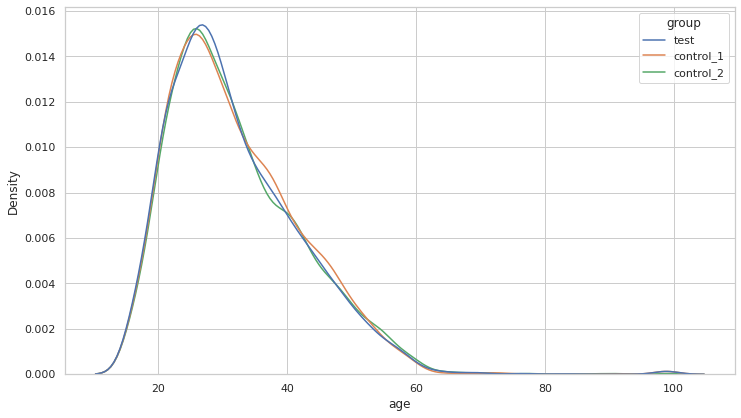

In [62]:
sns.kdeplot(data=users, x='age', hue='group');

In [63]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='age', group='group', method='normaltest')

,W,pval,normal
test,977.341332,5.929614e-213,False
control_1,915.044035,1.998538e-199,False
control_2,628.103559,4.064857e-137,False


In [64]:
# проверим дисперсии Leven
pg.homoscedasticity(data=users, dv='age', group='group')

,W,pval,equal_var
levene,0.383004,0.681818,True


In [65]:
# проверим различия средних значений ANOVA
pg.anova(data=users, dv='age', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,0.478342,0.619821,0.000074


H0 pvalue>0.05

Сравним без выбросов

In [66]:
age = users[users.age < 65]

In [67]:
# доля пользователей без выбросов
age.uid.nunique() / users.uid.nunique()

0.9961276332094176

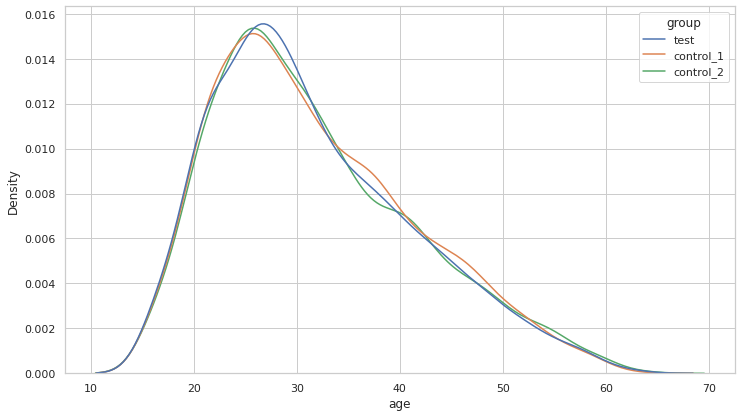

In [68]:
sns.kdeplot(data=age, x='age', hue='group');

In [69]:
# проверим нормальность распределения Normaltest
pg.normality(data=age, dv='age', group='group', method='normaltest')

,W,pval,normal
test,283.077344,3.392624e-62,False
control_1,261.270512,1.844290e-57,False
control_2,288.852701,1.889875e-63,False


In [70]:
# проверим дисперсии
pg.homoscedasticity(data=age, dv='age', group='group')

,W,pval,equal_var
levene,0.685713,0.50375,True


In [71]:
# проверим различия средних значений ANOVA
pg.anova(data=age, dv='age', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12859,0.769734,0.463158,0.00012


H1 pvalue<0.05

In [72]:
# не нормальные распределения, смотрим все вместе
pg.pairwise_gameshowell(data=age, dv='age', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control_1,control_2,31.895930,31.884208,0.011722,0.210524,0.055678,8564.872479,0.900000,0.001203
1,control_1,test,31.895930,31.664957,0.230973,0.208479,1.107895,8610.937314,0.509765,0.023874
2,control_2,test,31.884208,31.664957,0.219251,0.210383,1.042152,8531.066323,0.547370,0.022555


In [73]:
age_control_1 = age[age.group == 'control_1'].age
age_control_2 = age[age.group == 'control_2'].age

In [74]:
# тест Mann Whitney
pg.mwu(age_control_1, age_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9215105.0,two-sided,0.801645,-0.003131,0.501566


H0 pvalue>0.05

### Смотрим attraction_coeff

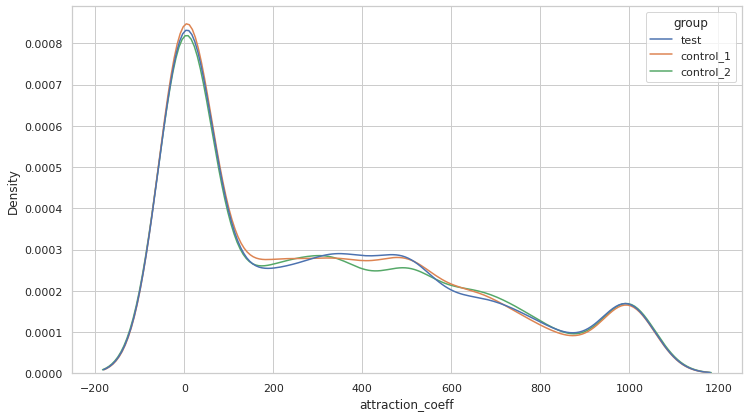

In [75]:
sns.kdeplot(data=users, x='attraction_coeff', hue='group');

In [76]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='attraction_coeff', group='group', method='normaltest')

,W,pval,normal
test,513.994620,2.440543e-112,False
control_1,491.135681,2.245132e-107,False
control_2,551.367622,1.870863e-120,False


In [77]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='attraction_coeff', group='group')

,W,pval,equal_var
levene,0.780525,0.458187,True


In [78]:
# проверим различия средних значений ANOVA
pg.anova(data=users, dv='attraction_coeff', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,0.386945,0.679136,0.00006


H0 pvalue>0.05

### Смотрим coins

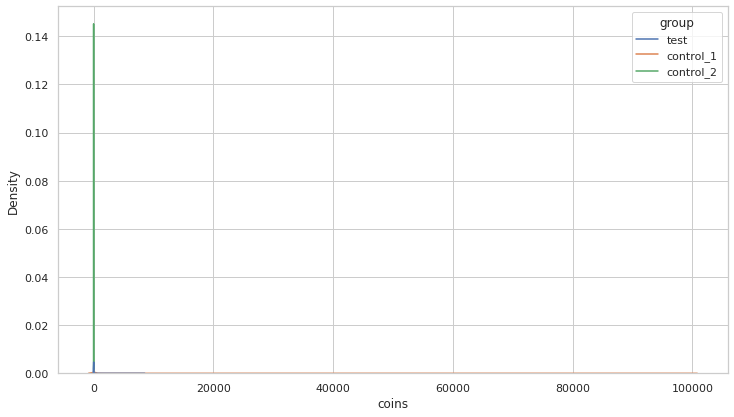

In [79]:
sns.kdeplot(data=users, x='coins', hue='group');

In [80]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='coins', group='group', method='normaltest')

,W,pval,normal
test,14916.221288,0.0,False
control_1,15108.258841,0.0,False
control_2,13097.914460,0.0,False


In [81]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='coins', group='group')

,W,pval,equal_var
levene,0.958288,0.383576,True


In [82]:
# не равные дисперсии, не нормальное распределение, проверим различия средних значений ANOVA Welch
pg.welch_anova(data=users, dv='coins', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,5771.734036,1.246345,0.287631,0.000148


H1 pvalue<0.05

In [83]:
b_control_1 = users[users.group == 'control_1'].coins
b_control_2 = users[users.group == 'control_2'].coins
len(b_control_1), len(b_control_2)

(4340, 4264)

In [84]:
# сравним средние Mann Whitney
pg.mwu(b_control_1, b_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9248835.5,two-sided,0.863343,0.000437,0.499781


H0 pvalue>0.05

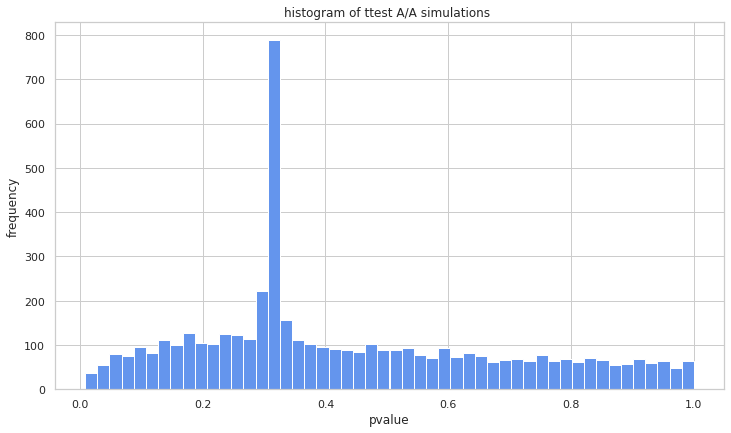

α=0.05, FPR=0.0184


In [85]:
# проведём бутстрап анализ
result = simulation(b_control_1, b_control_2, size=400)
graph(result)

H0 FPR<α

Сравним без выбросов

In [86]:
# доля coins < 250, среди пользователей с монетами
users[(users.coins > 0) & (users.coins < 250)].uid.nunique() / users[users.coins > 0].uid.nunique()

0.9588235294117647

In [87]:
# доля coins < 250, среди всех пользователей
users[users.coins < 250].uid.nunique() / users.uid.nunique()

0.9994578686493185

In [88]:
# рассмотрим тех у кого есть от 1 до 250 монет
coins = users[(users.coins > 0) & (users.coins < 250)]

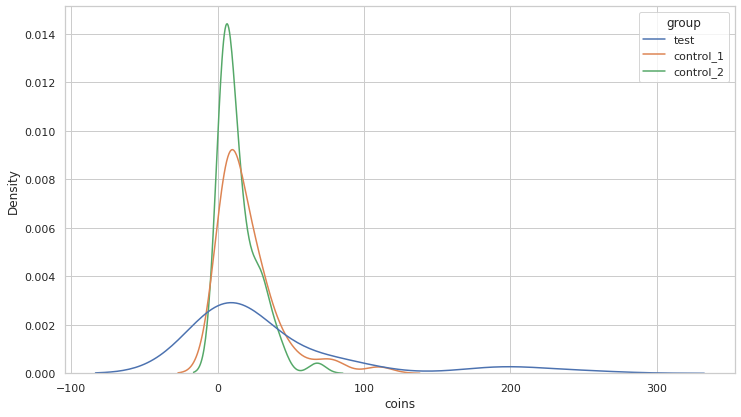

In [89]:
sns.kdeplot(data=coins, x='coins', hue='group');

In [90]:
# проверим нормальность распределения Normaltest
pg.normality(data=coins, dv='coins', group='group', method='normaltest')

,W,pval,normal
test,33.390461,5.615048e-08,False
control_1,40.954911,1.278657e-09,False
control_2,29.234592,4.485274e-07,False


In [91]:
# проверим дисперсии
pg.homoscedasticity(data=coins, dv='coins', group='group')

,W,pval,equal_var
levene,6.40943,0.0021,False


In [92]:
# не равные дисперсии, не нормальное распределение, проверим различия средних значений ANOVA Welch
pg.welch_anova(data=coins, dv='coins', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,82.208775,4.5374,0.013514,0.063346


H1 pvalue<0.05

In [93]:
coins_control_1 = coins[coins.group == 'control_1'].coins
coins_control_2 = coins[coins.group == 'control_2'].coins
len(coins_control_1), len(coins_control_2)

(58, 60)

In [94]:
# сравним средние Mann Whitney
pg.mwu(coins_control_1, coins_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,2113.5,two-sided,0.04378,-0.214655,0.607328


H1 pvalue<0.05

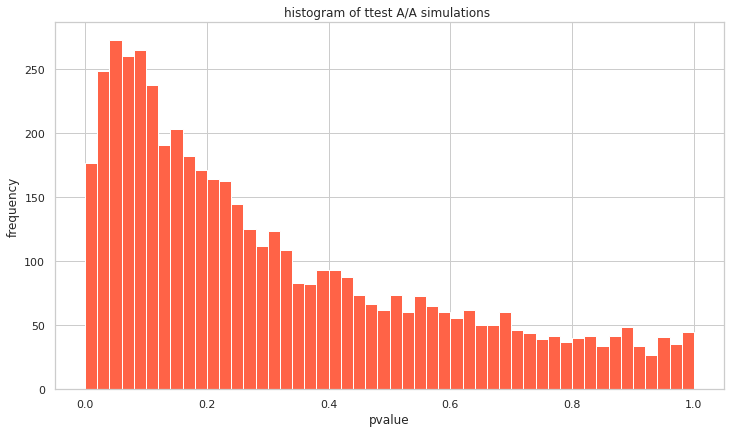

α=0.05, FPR=0.1098


In [95]:
result = simulation(coins_control_1, coins_control_2, size=20)
graph(result)

H1 FPR>α

### Смотрим country
Мы знаем что среди групп есть небольшое количество стран значения которых не входят больше чем в одну группу.  
Мы можем сравнить распределения только тех стран, которые находятся во всех группах.

In [96]:
# отбираем страны присутствующие во всех группах
country = users[users.country.isin(overall)]

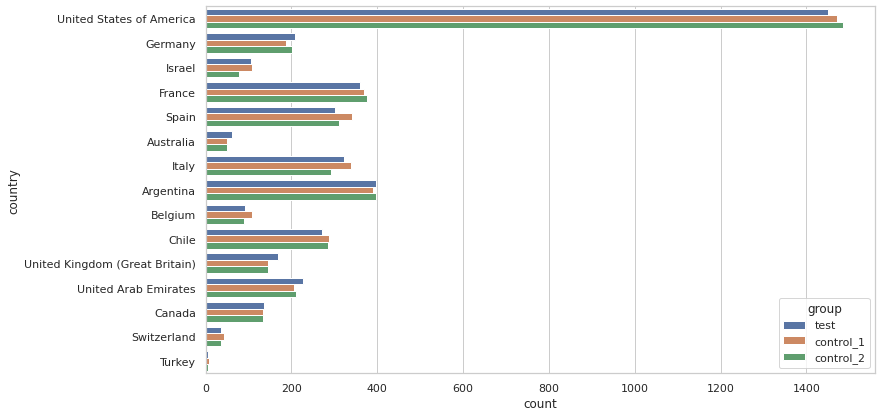

In [97]:
sns.countplot(data=country, y='country', hue='group');

In [98]:
# таблица сопряжённости
country_table = pd.crosstab(country.country, country.group).reset_index()
country_table.columns = ['country', 'control_1', 'control_2', 'test']
country_table = country_table[['country', 'control_1', 'control_2']]
country_table

,country,control_1,control_2
0,Argentina,389,397
1,Australia,50,51
2,Belgium,108,90
3,Canada,134,134
4,Chile,287,286
5,France,370,376
6,Germany,188,202
7,Israel,109,78
8,Italy,338,293
9,Spain,342,310


In [99]:
# сравниваем через Chi2
results = pg.chi2_independence(country, x='country', y='group')
results[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,22.632074,28.0,0.751225,0.030171,0.390360
1,cressie-read,0.666667,22.651620,28.0,0.750270,0.030184,0.390737
2,log-likelihood,0.000000,22.708553,28.0,0.747484,0.030222,0.391837
3,freeman-tukey,-0.500000,22.767125,28.0,0.744604,0.030261,0.392969
4,mod-log-likelihood,-1.000000,22.839608,28.0,0.741025,0.030309,0.394369
5,neyman,-2.000000,23.027691,28.0,0.731653,0.030434,0.398004


H0 pvalue>0.05

### Смотрим visit_days_count

In [100]:
users['visit_days_list'] = users.visit_days.apply(lambda x: [] if type(x) == float else x.split(','))
users['visit_days_count'] = users.visit_days_list.apply(lambda x: len(x))
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_days_list,visit_days_count
0,892309896,27,685,0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0,0,0,test,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",14
1,892044516,27,0,0,Germany,NaN,1,24,30,0,0,0,0,test,[],0
2,892185708,45,44,0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0,0,0,test,"[1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16,...",20
3,892130292,32,0,0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0,0,0,test,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12
4,891406035,27,1000,0,France,NaN,1,24,30,1,1,0,0,test,[],0


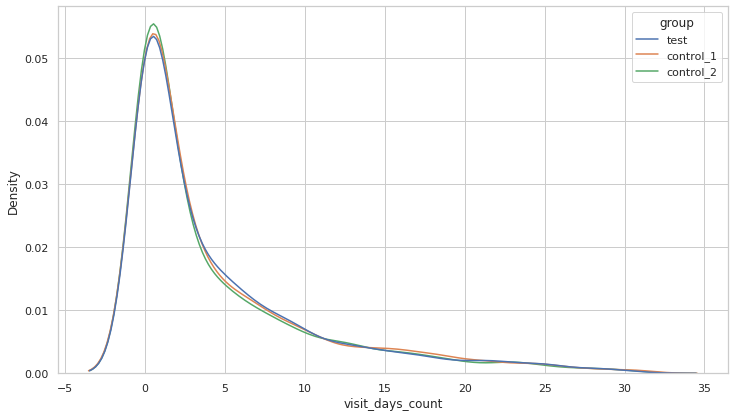

In [101]:
sns.kdeplot(data=users, x='visit_days_count', hue='group');

In [102]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='visit_days_count', group='group', method='normaltest')

,W,pval,normal
test,1446.017317,0.0,False
control_1,1434.426771,0.0,False
control_2,1468.996018,0.0,False


In [103]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='visit_days_count', group='group')

,W,pval,equal_var
levene,0.641204,0.526675,True


In [104]:
# проверим различия средних значений
pg.anova(data=users, dv='visit_days_count', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,1.130019,0.323059,0.000175


H0 pvalue>0.05

### Смотрим visit_days_list по средним значениям посещений пользователя на определённый день

In [105]:
# собирает список из значений списка списков
# если список в списке пустой - добавляет 0
def date_hist(data):
    result = []
    for list_ in data:
        if len(list_) == 0:
            result.append(0)
        else:
            for i in list_:
                result.append(int(i))
    return result

# возращает список списков, всех дней посещений всех пользователей по группам
def get_graph_dates(data):
    groups = data.group.unique().tolist()
    kde = []
    result = {}
    result
    for group in groups:
        data_group = data[data.group == group]
        list_data = date_hist(data_group.visit_days_list)
        kde.append(list_data)
        result[group] = list_data
    sns.kdeplot(data=kde)
    
    return result

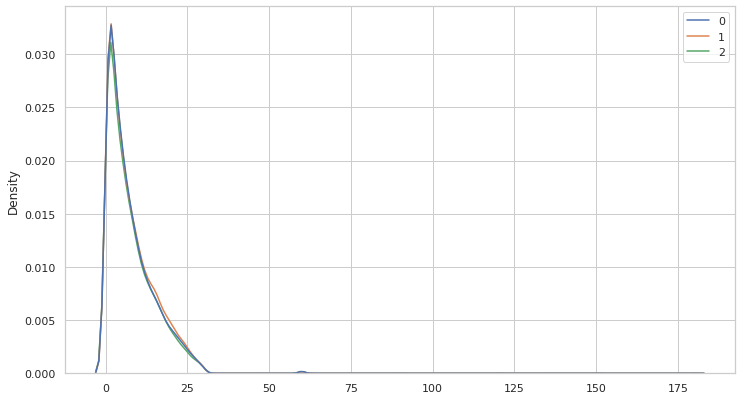

In [106]:
dates = get_graph_dates(users)

In [107]:
# проверим дисперсии
scipy.stats.levene(dates['control_1'], dates['control_2'])

LeveneResult(statistic=3.0381401366784138, pvalue=0.08133640268251194)

H0 pvalue>0.05

In [108]:
# нормальность распределения
scipy.stats.normaltest(dates['control_1'])

NormaltestResult(statistic=13710.540698184379, pvalue=0.0)

H1 pvalue<0.05

In [109]:
# нормальность распределения
scipy.stats.normaltest(dates['control_2'])

NormaltestResult(statistic=17571.723053742862, pvalue=0.0)

H1 pvalue<0.05

In [110]:
# проверим различия средних значений
scipy.stats.f_oneway(dates['control_1'], dates['control_2'])

F_onewayResult(statistic=4.9516526443393465, pvalue=0.02607105606132515)

H1 pvalue<0.05

In [111]:
# не нормальные распределения, Mann Whitney
scipy.stats.mannwhitneyu(dates['control_1'], dates['control_2'], alternative='two-sided')

MannwhitneyuResult(statistic=221281177.0, pvalue=0.011604694473615944)

H1 pvalue<0.05

### Смотрим gender

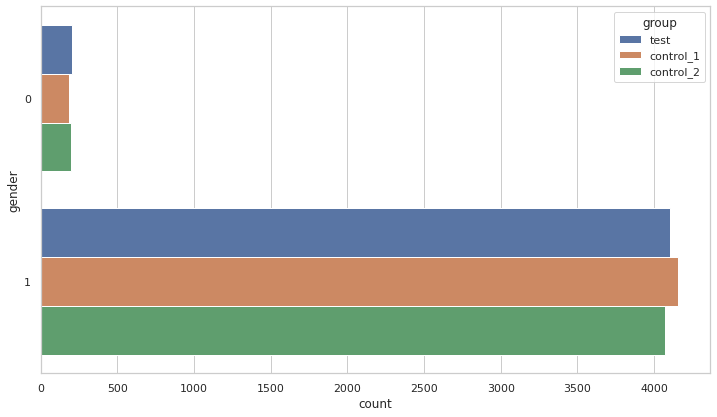

In [112]:
sns.countplot(data=users, y='gender', hue='group');

In [113]:
gender_table = pd.crosstab(users.gender, users.group).reset_index().drop(columns='gender').T.reset_index()
gender_table.columns = ['group','woman', 'man']
gender_table

,group,woman,man
0,control_1,182,4158
1,control_2,195,4069
2,test,202,4106


In [114]:
expected, observed, stats = pg.chi2_independence(users, x='gender', y='group')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.356471,2.0,0.507512,0.010250,0.165041
1,cressie-read,0.666667,1.360305,2.0,0.506540,0.010264,0.165395
2,log-likelihood,0.000000,1.368221,2.0,0.504539,0.010294,0.166125
3,freeman-tukey,-0.500000,1.374379,2.0,0.502988,0.010317,0.166693
4,mod-log-likelihood,-1.000000,1.380729,2.0,0.501393,0.010341,0.167279
5,neyman,-2.000000,1.394016,2.0,0.498073,0.010391,0.168506


H0 pvalue>0.05

## Смотрим age_filter_start

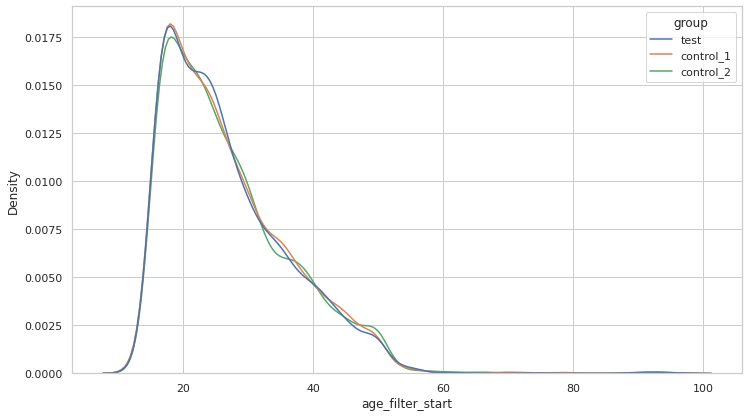

In [115]:
sns.kdeplot(data=users, x='age_filter_start', hue='group');

In [116]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='age_filter_start', group='group', method='normaltest')

,W,pval,normal
test,1032.453502,6.391026e-225,False
control_1,769.022657,1.020591e-167,False
control_2,921.935386,6.371982e-201,False


In [117]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='age_filter_start', group='group')

,W,pval,equal_var
levene,0.711881,0.49074,True


In [118]:
# проверим различия средних значений
pg.anova(data=users, dv='age_filter_start', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,0.785165,0.456066,0.000122


H0 pvalue>0.05

Посмотрим без выбросов

In [119]:
# доля пользователей без выбросов
len(users[users.age_filter_start < 60].age_filter_start) / len(users.age_filter_start)

0.9975216852540273

In [120]:
age_filter_start = users[users.age_filter_start < 60]

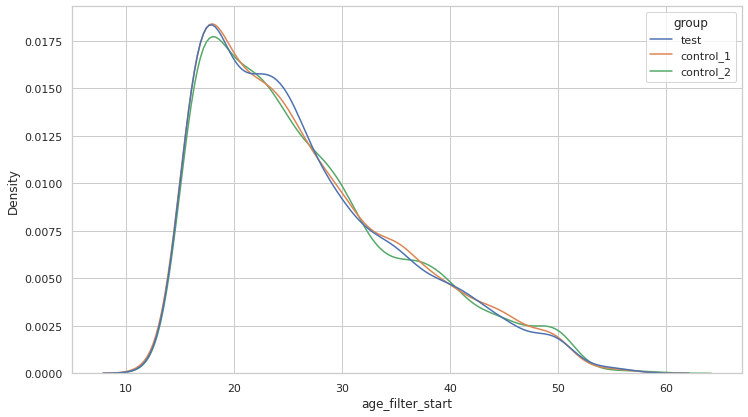

In [121]:
sns.kdeplot(data=age_filter_start, x='age_filter_start', hue='group');

In [122]:
# проверим нормальность распределения Normaltest
pg.normality(data=age_filter_start, dv='age_filter_start', group='group', method='normaltest')

,W,pval,normal
test,411.257125,4.973361e-90,False
control_1,387.658976,6.620991e-85,False
control_2,400.005145,1.380341e-87,False


In [123]:
# проверим дисперсии
pg.homoscedasticity(data=age_filter_start, dv='age_filter_start', group='group')

,W,pval,equal_var
levene,0.702769,0.495231,True


In [124]:
# проверим различия средних значений
pg.anova(data=age_filter_start, dv='age_filter_start', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12877,0.648754,0.522714,0.000101


H0 pvalue>0.05

### Смотрим age_filter_end

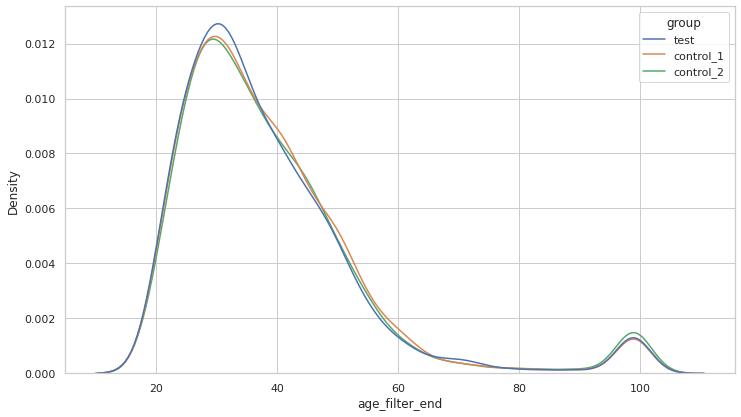

In [125]:
sns.kdeplot(data=users, x='age_filter_end', hue='group');

In [126]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='age_filter_end', group='group', method='normaltest')

,W,pval,normal
test,1792.875436,0.0,False
control_1,1733.768368,0.0,False
control_2,1743.599233,0.0,False


In [127]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='age_filter_end', group='group')

,W,pval,equal_var
levene,1.118762,0.326716,True


In [128]:
# проверим различия средних значений
pg.anova(data=users, dv='age_filter_end', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,1.931912,0.144913,0.000299


H0 pvalue>0.05

### Смотрим views_count

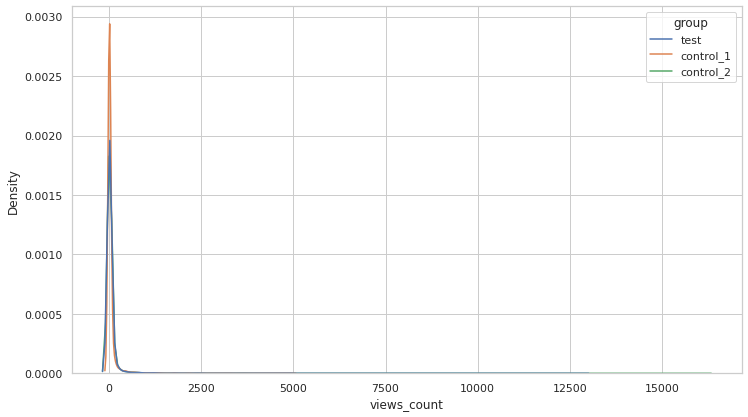

In [129]:
sns.kdeplot(data=users, x='views_count', hue='group');

In [130]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='views_count', group='group', method='normaltest')

,W,pval,normal
test,10073.085884,0.0,False
control_1,8066.097566,0.0,False
control_2,11774.894047,0.0,False


In [131]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='views_count', group='group')

,W,pval,equal_var
levene,0.563631,0.569153,True


In [132]:
# не равные дисперсии, не нормальное распределение, проверим различия средних значений ANOVA Welch
pg.welch_anova(data=users, dv='views_count', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,8153.082412,0.548502,0.577836,0.000087


H0 pvalue>0.05

In [133]:
views_count_control_1 = users[users.group == 'control_1'].views_count
views_count_control_2 = users[users.group == 'control_2'].views_count
len(views_count_control_1), len(views_count_control_2)

(4340, 4264)

In [134]:
# сравним средние Mann Whitney
pg.mwu(views_count_control_1, views_count_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9347993.0,two-sided,0.406726,-0.010279,0.50514


H1 pvalue<0.05

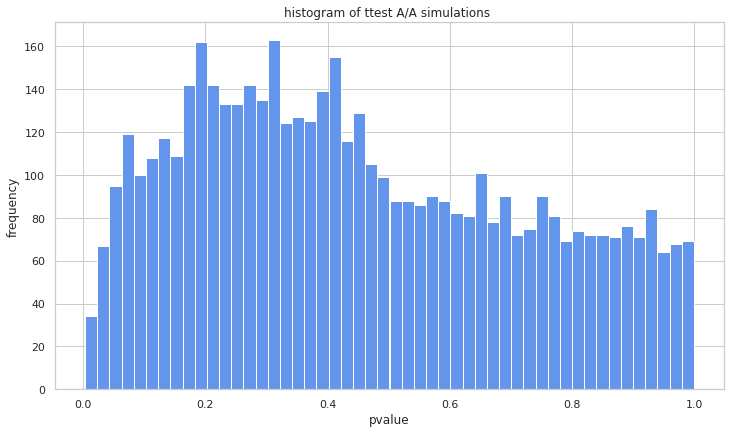

α=0.05, FPR=0.0266


In [135]:
# проведём bootstrap тест
result = simulation(views_count_control_1, views_count_control_2)
graph(result)

H0 FPR<α

Проверим без выбросов

In [136]:
# избавимся от выбросов в views_count
views_count = users[users.views_count < 170]

In [137]:
# доля views_count < 170
views_count.uid.nunique() / users.uid.nunique()

0.9519826517967782

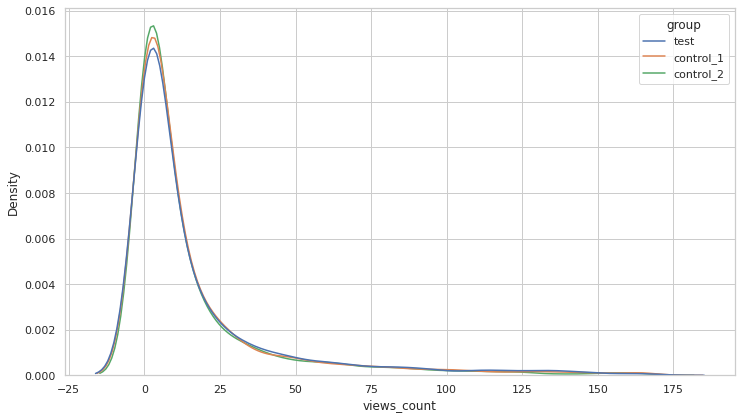

In [138]:
sns.kdeplot(data=views_count, x='views_count', hue='group');

In [139]:
# проверим нормальность распределения Normaltest
pg.normality(data=views_count, dv='views_count', group='group', method='normaltest')

,W,pval,normal
test,2314.137057,0.0,False
control_1,2489.151281,0.0,False
control_2,2513.701059,0.0,False


In [140]:
# проверим дисперсии
pg.homoscedasticity(data=views_count, dv='views_count', group='group')

,W,pval,equal_var
levene,3.832479,0.021682,False


In [141]:
# тест на равенство дисперсий не пройден, проведем Welch тест
pg.welch_anova(data=views_count, dv='views_count', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,8184.181951,3.730067,0.024032,0.000595


H1 pvalue<0.05

In [142]:
views_count_control_1 = views_count[views_count.group == 'control_1'].views_count
views_count_control_2 = views_count[views_count.group == 'control_2'].views_count
len(b_control_1), len(b_control_2)

(4340, 4264)

In [143]:
# сравним средние Mann Whitney
pg.mwu(views_count_control_1, views_count_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,8460162.0,two-sided,0.438616,-0.00983,0.504915


H1 pvalue<0.05

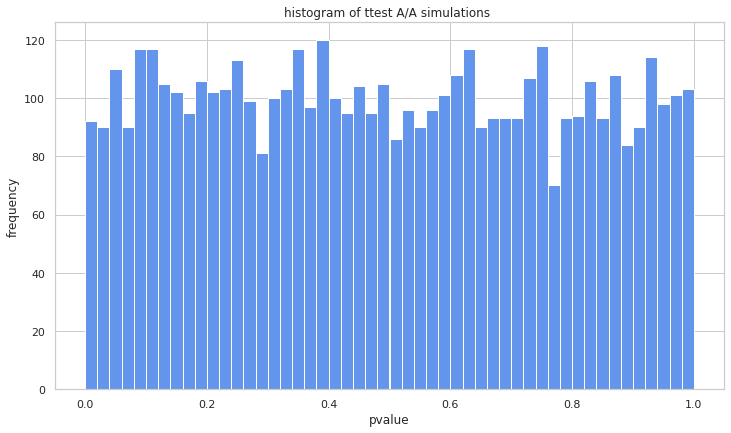

α=0.05, FPR=0.047


In [144]:
# проведём bootstrap тест
result = simulation(views_count_control_1, views_count_control_2)
graph(result)

H0 FPR<α

### Смотрим was_premium

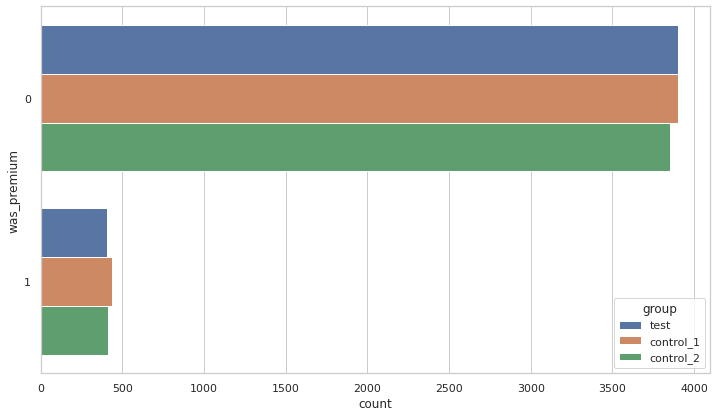

In [145]:
sns.countplot(data=users, y='was_premium', hue='group');

In [146]:
was_table = pd.crosstab(users.was_premium, users.group).reset_index().drop(columns='was_premium').T.reset_index()
was_table.columns = ['group','no_was_premium', 'was_premium']
was_table

,group,no_was_premium,was_premium
0,control_1,3904,436
1,control_2,3853,411
2,test,3900,408


In [147]:
expected, observed, stats = pg.chi2_independence(users, x='was_premium', y='group')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.862904,2.0,0.649565,0.008175,0.120594
1,cressie-read,0.666667,0.861974,2.0,0.649867,0.008171,0.120513
2,log-likelihood,0.000000,0.860153,2.0,0.650459,0.008162,0.120353
3,freeman-tukey,-0.500000,0.858821,2.0,0.650893,0.008156,0.120237
4,mod-log-likelihood,-1.000000,0.857518,2.0,0.651317,0.008149,0.120123
5,neyman,-2.000000,0.855000,2.0,0.652137,0.008137,0.119902


H0 pvalue>0.05

### Смотрим is_premium

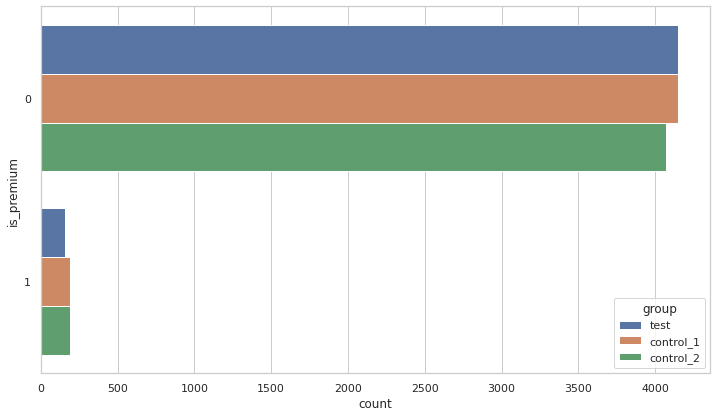

In [148]:
sns.countplot(data=users, y='is_premium', hue='group');

In [149]:
is_table = pd.crosstab(users.is_premium, users.group).reset_index().drop(columns='is_premium').T.reset_index()
is_table.columns = ['group','no_is_premium', 'is_premium']
is_table

,group,no_is_premium,is_premium
0,control_1,4148,192
1,control_2,4073,191
2,test,4151,157


In [150]:
result = pg.chi2_independence(users, x='was_premium', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.862904,2.0,0.649565,0.008175,0.120594
1,cressie-read,0.666667,0.861974,2.0,0.649867,0.008171,0.120513
2,log-likelihood,0.000000,0.860153,2.0,0.650459,0.008162,0.120353
3,freeman-tukey,-0.500000,0.858821,2.0,0.650893,0.008156,0.120237
4,mod-log-likelihood,-1.000000,0.857518,2.0,0.651317,0.008149,0.120123
5,neyman,-2.000000,0.855000,2.0,0.652137,0.008137,0.119902


H0 pvalue>0.05

### Смотрим total_revenue

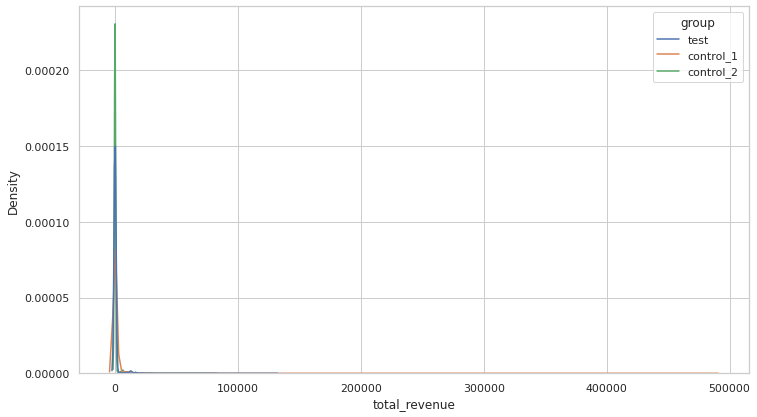

In [151]:
sns.kdeplot(data=users, x='total_revenue', hue='group');

In [152]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='total_revenue', group='group', method='normaltest')

,W,pval,normal
test,8916.392317,0.0,False
control_1,13980.768501,0.0,False
control_2,7811.263351,0.0,False


In [153]:
# проверим дисперсии
pg.homoscedasticity(data=users, dv='total_revenue', group='group')

,W,pval,equal_var
levene,0.739983,0.477142,True


In [154]:
# проверим различия средних значений
pg.anova(data=users, dv='total_revenue', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12909,0.739983,0.477142,0.000115


H1 pvalue<0.05

In [155]:
total_revenue_control_1 = users[users.group == 'control_1'].total_revenue
total_revenue_control_2 = users[users.group == 'control_2'].total_revenue

In [156]:
# сравним средние Mann Whitney
pg.mwu(total_revenue_control_1, total_revenue_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9257464.0,two-sided,0.910896,-0.000495,0.500248


H0 pvalue>0.05

Посмотрим без выбросов

In [157]:
# доля total_revenue < 50000, среди пользователей с total_revenue > 0
len(users[(users.total_revenue > 0) & (users.total_revenue < 50000)]) / len(users[users.total_revenue > 0])

0.9752380952380952

In [158]:
# доля total_revenue < 50000
len(users[users.total_revenue < 50000]) / len(users)

0.9989931846344485

In [159]:
# избавимся от выбросов в views_count
total_revenue = users[(users.total_revenue > 0) & (users.total_revenue < 50000)]

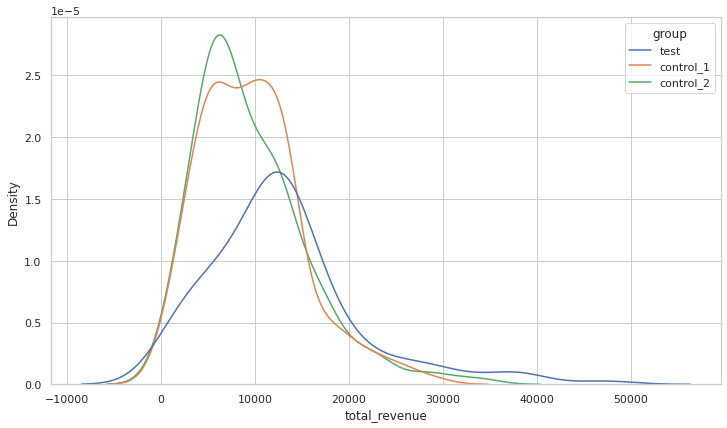

In [160]:
sns.kdeplot(data=total_revenue, x='total_revenue', hue='group');

In [161]:
# проверим нормальность распределения Normaltest
pg.normality(data=total_revenue, dv='total_revenue', group='group', method='normaltest')

,W,pval,normal
test,45.177869,1.547927e-10,False
control_1,23.132187,9.482206e-06,False
control_2,45.907060,1.075000e-10,False


In [162]:
# проверим дисперсии
pg.homoscedasticity(data=total_revenue, dv='total_revenue', group='group')

,W,pval,equal_var
levene,3.376584,0.034931,False


In [163]:
# проверим различия средних значений
pg.welch_anova(data=total_revenue, dv='total_revenue', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,305.500377,9.699168,0.000082,0.049607


In [164]:
total_revenue_control_1 = total_revenue[total_revenue.group == 'control_1'].total_revenue
total_revenue_control_2 = total_revenue[total_revenue.group == 'control_2'].total_revenue

H1 pvalue<0.05

In [165]:
# сравним средние Mann Whitney
pg.mwu(total_revenue_control_1, total_revenue_control_2, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,17870.0,two-sided,0.519687,-0.038652,0.519326


H0 pvalue>0.05

### Посмотрим на показатели пользовательской активности между группами

In [166]:
# соберём данные
transact = pd.concat([transactions_control_1, transactions_control_2, transactions_test])
transact = transact.merge(users[['uid', 'group']], on='uid')

# уберём страны не пересекающиеся в группах
transact = transact[transact.country.isin(overall)]

# добавим значений
transact['joined_at'] = transact.joined_at.astype('datetime64[ns]')
transact['joined'] = transact['joined_at'].dt.strftime('%Y-%m')

transact.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,joined
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727,147,trial_vip_popup,trial_premium,control_1,2017-05
1,891319275,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728,146,ad_to_photo,coins,control_1,2017-05
2,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,trial_vip_popup,trial_premium,control_1,2017-10
3,891822480,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911,19,none,coins,control_1,2017-10
4,891822480,Italy,2017-10-26 22:27:00,2017-01-11 16:50:00,1898,19,none,coins,control_1,2017-10


### Смотрим country

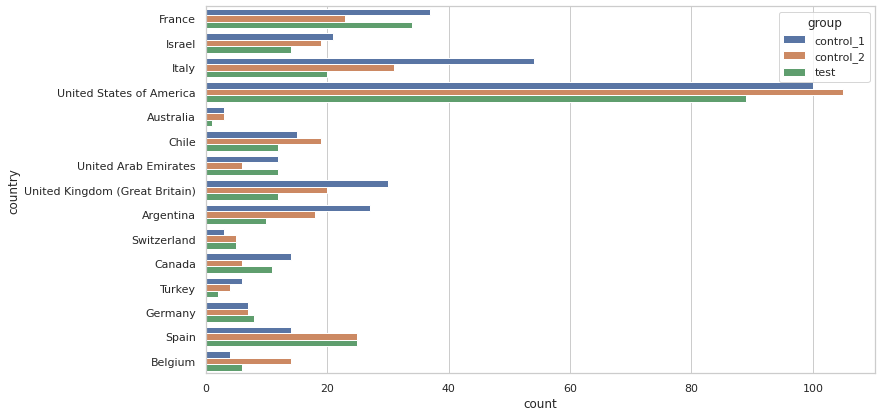

In [167]:
sns.countplot(data=transact, y='country', hue='group');

In [168]:
country = pd.crosstab(transact.country, transact.group).reset_index()
country.columns = ['country','control_1', 'control_2', 'test']
country = country.replace([0, 1, 2, 3, 4], np.nan).dropna().set_index('country')
# так как мы не можем сравнивать страны где значения меньше 5
over = country.index.tolist()
country

,control_1,control_2,test
country,,,
Argentina,27.0,18.0,10.0
Canada,14.0,6.0,11.0
Chile,15.0,19.0,12.0
France,37.0,23.0,34.0
Germany,7.0,7.0,8.0
Israel,21.0,19.0,14.0
Italy,54.0,31.0,20.0
Spain,14.0,25.0,25.0
United Arab Emirates,12.0,6.0,12.0


In [169]:
result = pg.chi2_independence(transact[transact.country.isin(over)], x='country', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,37.475094,20.0,0.010257,0.147865,0.739052
1,cressie-read,0.666667,37.831003,20.0,0.009286,0.148566,0.744356
2,log-likelihood,0.000000,38.806731,20.0,0.007046,0.150469,0.758516
3,freeman-tukey,-0.500000,39.791742,20.0,0.005307,0.152367,0.772245
4,mod-log-likelihood,-1.000000,41.020019,20.0,0.003703,0.154701,0.788571
5,neyman,-2.000000,44.330114,20.0,0.001359,0.160821,0.828273


H1 pvalue<0.05

### Смотрим joined_at

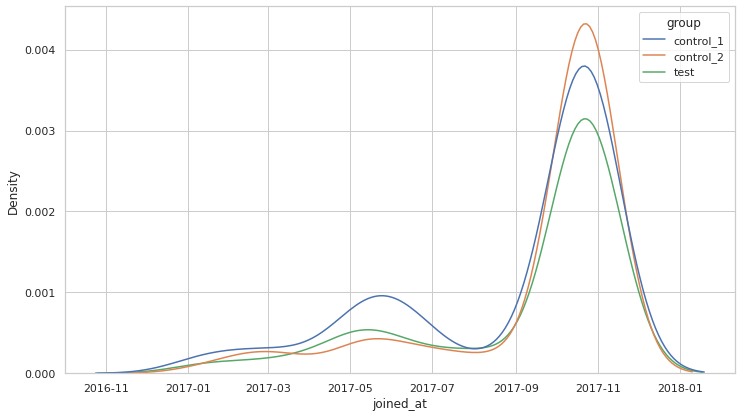

In [170]:
sns.kdeplot(data=transact, x='joined_at', hue='group');

In [171]:
joined = pd.crosstab(transact.joined, transact.group).reset_index()
joined.columns = ['joined','control_1', 'control_2', 'test']
joined = joined.replace([0, 1, 2, 3, 4], np.nan).dropna().set_index('joined')
# так как мы не можем сравнивать страны где значения меньше 5
over = joined.index.tolist()
joined#.head()

,control_1,control_2,test
joined,,,
2017-03,9.0,8.0,5.0
2017-05,35.0,16.0,22.0
2017-06,30.0,10.0,10.0
2017-07,6.0,8.0,7.0
2017-10,229.0,237.0,189.0


In [172]:
result = pg.chi2_independence(transact[transact.joined.isin(over)], x='joined', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,19.347348,8.0,0.013108,0.108549,0.570462
1,cressie-read,0.666667,19.276661,8.0,0.013448,0.108350,0.568569
2,log-likelihood,0.000000,19.310876,8.0,0.013283,0.108446,0.569485
3,freeman-tukey,-0.500000,19.490668,8.0,0.012445,0.108950,0.574287
4,mod-log-likelihood,-1.000000,19.806199,8.0,0.011095,0.109828,0.582645
5,neyman,-2.000000,20.873532,8.0,0.007491,0.112749,0.610249


H1 pvalue<0.05

### Смотрим revenue

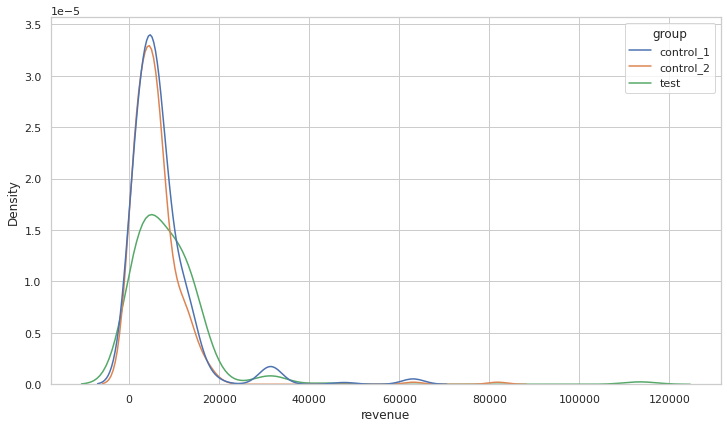

In [173]:
sns.kdeplot(data=transact, x='revenue', hue='group');

In [174]:
transact.groupby('group').agg({'revenue': 'mean'}).reset_index()

,group,revenue
0,control_1,7103.582133
1,control_2,5968.449180
2,test,8876.808429


Средний чек значительно различается

### Смотрим from_page

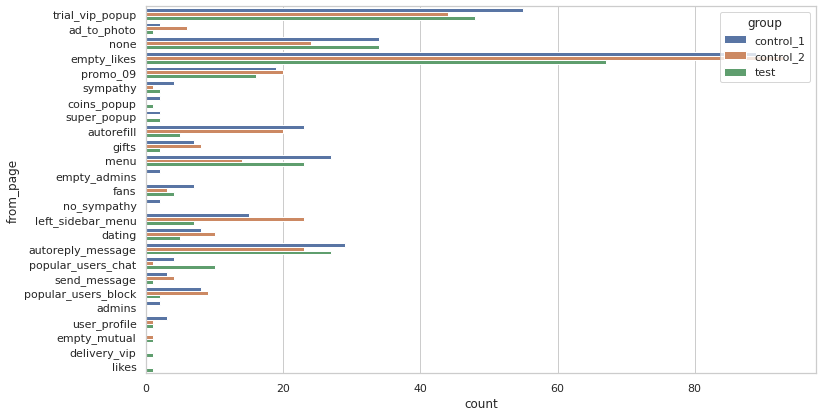

In [175]:
sns.countplot(data=transact, y='from_page', hue='group');

In [176]:
from_page = pd.crosstab(transact.group, transact.from_page).T
from_page = from_page.replace([0, 1, 2, 3, 4], np.nan).dropna()
over = from_page.index.tolist()
from_page

group,control_1,control_2,test
from_page,,,
autorefill,23.0,20.0,5.0
autoreply_message,29.0,23.0,27.0
dating,8.0,10.0,5.0
empty_likes,89.0,93.0,67.0
left_sidebar_menu,15.0,23.0,7.0
menu,27.0,14.0,23.0
none,34.0,24.0,34.0
promo_09,19.0,20.0,16.0
trial_vip_popup,55.0,44.0,48.0


In [177]:
result = pg.chi2_independence(transact[transact.from_page.isin(over)], x='from_page', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,28.220210,16.0,0.029757,0.132641,0.627654
1,cressie-read,0.666667,28.719985,16.0,0.025894,0.133810,0.637608
2,log-likelihood,0.000000,30.146284,16.0,0.017258,0.137093,0.665168
3,freeman-tukey,-0.500000,31.678518,16.0,0.011008,0.140534,0.693321
4,mod-log-likelihood,-1.000000,33.725863,16.0,0.005914,0.145004,0.728504
5,neyman,-2.000000,40.041744,16.0,0.000768,0.157999,0.819220


H1 pvalue<0.05

### Смотрим product_type

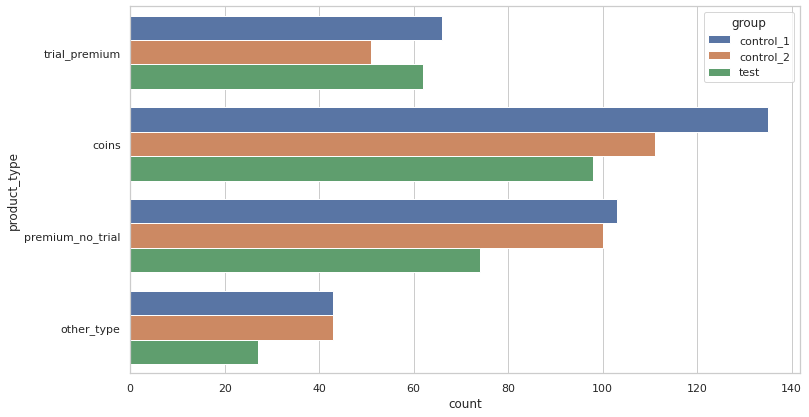

In [178]:
sns.countplot(data=transact, y='product_type', hue='group');

In [179]:
from_page = pd.crosstab(transact.group, transact.product_type).T
from_page

group,control_1,control_2,test
product_type,,,
coins,135,111,98
other_type,43,43,27
premium_no_trial,103,100,74
trial_premium,66,51,62


In [180]:
result = pg.chi2_independence(transact, x='product_type', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,6.512263,6.0,0.368313,0.059719,0.221803
1,cressie-read,0.666667,6.487751,6.0,0.370822,0.059607,0.221028
2,log-likelihood,0.000000,6.447838,6.0,0.374934,0.059423,0.219767
3,freeman-tukey,-0.500000,6.425763,6.0,0.377222,0.059321,0.219070
4,mod-log-likelihood,-1.000000,6.410338,6.0,0.378826,0.059250,0.218584
5,neyman,-2.000000,6.399237,6.0,0.379983,0.059199,0.218234


H1 pvalue<0.05

### Вывод:

Результаты тестов:

**users:**  

age - с выбросами: H0(ANOVA), без выбросов: H0(Mann Whitney)  
attraction_coeff - H0(ANOVA)  
coins - с выбросами: H0(bootstrap), без выбросов: H1(ANOVA Welch, Mann Whitney, bootstrap)  
country - H0(Chi2)  

visit_days преобразовали в:  
    visit_days_list (список номеров дней посещения) - H1(ANOVA, Mann Whitney)    
    visit_days_count (количество посещений) - H0(ANOVA)     

gender - H0(Chi2)  
age_filter_start - с выбросами: H0(ANOVA), без выбросов: H0(ANOVA)  
age_filter_end - H0(ANOVA)  
views_count - с выбросами: H0(bootstrap), без выбросов: H1(ANOVA Welch, Mann Whitney, bootstrap)  
was_premium - H0(Chi2)  
is_premium - H0(Chi2)   
total_revenue - с выбросами: H0(Mann Whitney), без выбросов: H0(Mann Whitney)

**transactions:**  
country - H1(Chi2)  
joined_at - H1(Chi2)  
revenue - (значительные различия)  
from_page - H1(Chi2)  
product_type - (значительные различия)  


Система сплитирования сработала корректно.  

Без учёта выбросов не прошли тесты колонки: coins, views_count  
visit_days - прошли тесты по количеству дней, однако по дням посещения с момента регистрации не прошли.

В таблице transactions значительные различия в revenue и product_type

## Сравнение групп

In [181]:
# понадобится для сравнения
users['attract_coeff'] = round(users.attraction_coeff / 100)
users['views'] = users.views_count.apply(lambda x: round(np.log(x), 1) if x>0 else 0) 

In [182]:
# объединим таблицы transactions
t_all = pd.concat([transactions_control_1, transactions_control_2, transactions_test])
t_all['trial_premium'] = t_all.product_type.apply(lambda x: 1 if x == 'trial_premium' else 0)
t_all['premium_no_trial'] = t_all.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)
t_all = t_all.merge(users.drop(columns=['group']), on=['uid', 'country'], how='outer')
t_all.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,trial_premium,premium_no_trial,...,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visit_days_list,visit_days_count,attract_coeff,views
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,1.0,0.0,...,24,30,2,1,1,13455,"[1, 2, 3]",3,0.0,0.7
1,891319275,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728.0,146.0,ad_to_photo,coins,0.0,0.0,...,24,30,2,1,1,13455,"[1, 2, 3]",3,0.0,0.7


In [183]:
# отберём только интересующие нас данные trial_premium и premium_no_trial
transactions = t_all[(t_all.trial_premium == 1) | (t_all.premium_no_trial == 1)]
transactions.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,trial_premium,premium_no_trial,...,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,visit_days_list,visit_days_count,attract_coeff,views
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,1.0,0.0,...,24,30,2,1,1,13455,"[1, 2, 3]",3,0.0,0.7
2,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,1.0,0.0,...,28,34,69,1,1,14586,"[1, 2, 4, 6, 7, 10, 11, 12, 13, 14, 15, 17, 18...",25,0.0,4.2


In [184]:
# добавим данных о пользователях
transactions = transactions.merge(users[['uid', 'group', 'country']], on=['uid', 'country'], how='outer')
transactions['cr1'] = transactions.revenue.apply(lambda x: 1 if x>0 else 0)
transactions.drop(columns=['payment_id', 'from_page', 'product_type'], inplace=True)
transactions.head(2)

,uid,country,joined_at,paid_at,revenue,trial_premium,premium_no_trial,age,attraction_coeff,coins,...,views_count,was_premium,is_premium,total_revenue,visit_days_list,visit_days_count,attract_coeff,views,group,cr1
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,1.0,0.0,27.0,0.0,0.0,...,2.0,1.0,1.0,13455.0,"[1, 2, 3]",3.0,0.0,0.7,control_1,1
1,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,1.0,0.0,31.0,43.0,0.0,...,69.0,1.0,1.0,14586.0,"[1, 2, 4, 6, 7, 10, 11, 12, 13, 14, 15, 17, 18...",25.0,0.0,4.2,control_1,1


In [185]:
# данные обо всех покупках
revenue_all_data = t_all.merge(users[['uid', 'group', 'country']], on=['uid', 'country'], how='outer')
revenue_all_data['cr1'] = revenue_all_data.revenue.apply(lambda x: 1 if x>0 else 0)
revenue_all_data.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,trial_premium,premium_no_trial,...,views_count,was_premium,is_premium,total_revenue,visit_days_list,visit_days_count,attract_coeff,views,group,cr1
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,1.0,0.0,...,2,1,1,13455,"[1, 2, 3]",3,0.0,0.7,control_1,1
1,891319275,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728.0,146.0,ad_to_photo,coins,0.0,0.0,...,2,1,1,13455,"[1, 2, 3]",3,0.0,0.7,control_1,1


In [186]:
# всего пользователей
users_by_group = revenue_all_data.groupby('group').agg({'uid': 'nunique'}).reset_index()
users_by_group.columns = ['group', 'users']
users_by_group

,group,users
0,control_1,4340
1,control_2,4264
2,test,4308


In [187]:
# всего покупателей
buyers_all = revenue_all_data[revenue_all_data.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
buyers_all.columns = ['group', 'buyers']
buyers_all

,group,buyers
0,control_1,192
1,control_2,187
2,test,146


In [188]:
# вся прибыль по группам
revenue_all = revenue_all_data.groupby('group').agg({'revenue': 'sum'}).reset_index()
revenue_all.columns = ['group', 'revenue_all']
revenue_all

,group,revenue_all
0,control_1,2493998.0
1,control_2,1907997.0
2,test,2332226.0


In [189]:
# покупателей premium по группам
buyers_by_group = transactions[transactions.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
buyers_by_group.columns = ['group', 'buyers_all_premium']
buyers_by_group

,group,buyers_all_premium
0,control_1,166
1,control_2,155
2,test,127


In [190]:
# посчитаем данные trial_premium и premium_no_trial по группам
trial_and_no = transactions.groupby(['uid', 'trial_premium', 'premium_no_trial', 'group']) \
    .agg({'country': 'first', 'revenue': 'sum', 'paid_at': 'count'}) \
    .rename(columns={'paid_at': 'purchases'}).reset_index()
trial_and_no.head()

,uid,trial_premium,premium_no_trial,group,country,revenue,purchases
0,891068079,0.0,1.0,control_2,Argentina,6292.0,1
1,891071157,0.0,1.0,test,United States of America,9100.0,1
2,891077727,0.0,1.0,control_2,Argentina,6292.0,1
3,891092322,0.0,1.0,control_1,Argentina,5278.0,1
4,891112263,0.0,1.0,control_2,United States of America,4680.0,1


In [191]:
t_and_no_by_gr = trial_and_no.groupby(['group', 'trial_premium', 'premium_no_trial']) \
    .agg({'uid': 'nunique', 'revenue': 'sum', 'purchases': 'sum'}).reset_index().drop(columns=['premium_no_trial'])
t_and_no_by_gr['ARPPU'] = round(t_and_no_by_gr['revenue'] / t_and_no_by_gr['uid'])
t_and_no_by_gr

,group,trial_premium,uid,revenue,purchases,ARPPU
0,control_1,0.0,99,779259.0,106,7871.0
1,control_1,1.0,67,772720.0,67,11533.0
2,control_2,0.0,102,744809.0,107,7302.0
3,control_2,1.0,53,643981.0,53,12151.0
4,test,0.0,67,810706.0,76,12100.0
5,test,1.0,61,800202.0,62,13118.0


In [192]:
# количество purchases
purchases = t_and_no_by_gr[['group', 'trial_premium', 'purchases']] \
    .pivot(index='group', columns='trial_premium', values='purchases').reset_index()
purchases.columns = ['group', 'purchases_premium_no_trial', 'purchases_trial_premium']
purchases

,group,purchases_premium_no_trial,purchases_trial_premium
0,control_1,106,67
1,control_2,107,53
2,test,76,62


In [193]:
# количество покупателей
uid = t_and_no_by_gr[['group', 'trial_premium', 'uid']] \
    .pivot(index='group', columns='trial_premium', values='uid').reset_index()
uid.columns = ['group', 'buyers_premium_no_trial', 'buyers_trial_premium']
uid

,group,buyers_premium_no_trial,buyers_trial_premium
0,control_1,99,67
1,control_2,102,53
2,test,67,61


In [194]:
# ARPPU по типам подписки
arppu = t_and_no_by_gr[['group', 'trial_premium', 'ARPPU']] \
    .pivot(index='group', columns='trial_premium', values='ARPPU').reset_index()
arppu.columns = ['group', 'arppu_premium_no_trial', 'arppu_trial_premium']
arppu

,group,arppu_premium_no_trial,arppu_trial_premium
0,control_1,7871.0,11533.0
1,control_2,7302.0,12151.0
2,test,12100.0,13118.0


In [195]:
# прибыль по группам, ARPU, ARPPU
revenue = t_and_no_by_gr[['group', 'trial_premium', 'revenue']] \
    .pivot(index='group', columns='trial_premium', values='revenue').reset_index()
revenue.columns = ['group', 'revenue_premium_no_trial', 'revenue_trial_premium']
revenue = revenue.merge(users_by_group, on='group').merge(buyers_by_group, on='group') \
    .merge(revenue_all, on='group').merge(buyers_all, on='group').merge(purchases, on='group')
revenue

,group,revenue_premium_no_trial,revenue_trial_premium,users,buyers_all_premium,revenue_all,buyers,purchases_premium_no_trial,purchases_trial_premium
0,control_1,779259.0,772720.0,4340,166,2493998.0,192,106,67
1,control_2,744809.0,643981.0,4264,155,1907997.0,187,107,53
2,test,810706.0,800202.0,4308,127,2332226.0,146,76,62


In [196]:
# добавим метрики
revenue['revenue_all_premium'] = revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']
revenue['ARPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['users'])
revenue['ARPPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['buyers_all_premium'])
revenue['share_revenue_premium_%'] = round((revenue['revenue_all_premium'] / revenue['revenue_all'])*100)
revenue['CR1_all_%'] = round(revenue['buyers'] / revenue['users'] * 100, 1)
revenue['CR1_premium_%'] = round(revenue['buyers_all_premium'] / revenue['users'] * 100, 1)
revenue['revenue_other'] = revenue['revenue_all'] - revenue['revenue_all_premium']
revenue['avg_check_premium_no_trial'] = round(revenue['revenue_premium_no_trial'] / revenue['purchases_premium_no_trial'])
revenue['avg_check_trial_premium'] = round(revenue['revenue_trial_premium'] / revenue['purchases_trial_premium'])
revenue

,group,revenue_premium_no_trial,revenue_trial_premium,users,buyers_all_premium,revenue_all,buyers,purchases_premium_no_trial,purchases_trial_premium,revenue_all_premium,ARPU,ARPPU,share_revenue_premium_%,CR1_all_%,CR1_premium_%,revenue_other,avg_check_premium_no_trial,avg_check_trial_premium
0,control_1,779259.0,772720.0,4340,166,2493998.0,192,106,67,1551979.0,358.0,9349.0,62.0,4.4,3.8,942019.0,7352.0,11533.0
1,control_2,744809.0,643981.0,4264,155,1907997.0,187,107,53,1388790.0,326.0,8960.0,73.0,4.4,3.6,519207.0,6961.0,12151.0
2,test,810706.0,800202.0,4308,127,2332226.0,146,76,62,1610908.0,374.0,12684.0,69.0,3.4,2.9,721318.0,10667.0,12906.0


In [197]:
# соберём всё вместе
all_data = revenue.merge(arppu, on='group').merge(uid, on='group').set_index('group')
all_data = all_data[['users', 'buyers', 'CR1_all_%', 'buyers_premium_no_trial', 'buyers_trial_premium',
    'buyers_all_premium', 'CR1_premium_%', 'revenue_premium_no_trial', 'revenue_trial_premium',
    'revenue_all_premium', 'revenue_other', 'revenue_all', 'share_revenue_premium_%', 'ARPU', 'arppu_premium_no_trial',
    'arppu_trial_premium', 'ARPPU', 'avg_check_premium_no_trial', 'avg_check_trial_premium']]

all_data = all_data.T
all_data['change_%'] = round(all_data['test'] / ((all_data['control_1'] + all_data['control_2']) / 2) - 1, 2) * 100
#all_data

In [198]:
# показатели 
all_data

group,control_1,control_2,test,change_%
users,4340.0,4264.0,4308.0,0.0
buyers,192.0,187.0,146.0,-23.0
CR1_all_%,4.4,4.4,3.4,-23.0
buyers_premium_no_trial,99.0,102.0,67.0,-33.0
buyers_trial_premium,67.0,53.0,61.0,2.0
buyers_all_premium,166.0,155.0,127.0,-21.0
CR1_premium_%,3.8,3.6,2.9,-22.0
revenue_premium_no_trial,779259.0,744809.0,810706.0,6.0
revenue_trial_premium,772720.0,643981.0,800202.0,13.0
revenue_all_premium,1551979.0,1388790.0,1610908.0,10.0


### Вывод:
Общие данные результата теста:  
(в качестве расчёта использовалось среднее значение контрольных групп)  

Негативные показатели:  
- Количество покупателей в тестовой группе снизилось на 23%  
- Общая конверсия в покупку снизилась на 23%, с 4,4 до 3,4 процентов от количества пользователей.  
- Количество покупателей по premium_no_trial снизилось на 33%, а trial_premium не изменилось, в целом premium покупок уменьшилось на 22%  

Позитивные показатели:  
- Прибыль увеличилась premium_no_trial на 6%, trial_premium на 13%, общая прибыль на 6% (только за счёт изменений в premium, прибыль от других продаж не изменилась). Доля premium в прибыли увеличилась на 2%  
- Прибыль с пользователя ARPU увеличилось на 9%  
- Больше всего изменился показатель количества прибыли с покупателя ARPPU c premium_no_trial увеличившись на 59%  
- ARPPU по trial_premium увеличился на 11%  
- Общий ARPPU увеличился на 39%  
- Средний чек premium_no_trial  в тестовой группе увеличился на 49%

### Посмотрим результаты на срезах

In [199]:
# объединим таблицы transactions
# добавляем колонки trial_premium, premium_no_trial
def union_transactions(data=[transactions_control_1, transactions_control_2, transactions_test]):
    result = pd.concat(data)
    result['trial_premium'] = result.product_type.apply(lambda x: 1 if x == 'trial_premium' else 0)
    result['premium_no_trial'] = result.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)
    #result = result.merge(users[['uid', 'country', 'age']], on=['uid', 'country'], how='outer')
    result = result.merge(users.drop(columns=['group']), on=['uid', 'country'], how='outer')
    return result

# получаем только покупки по промо
def get_only_premium(data):
    return data[(data.trial_premium == 1) | (data.premium_no_trial == 1)]

# добавим данных о пользователях
def set_users_data(data, users=users):
    data = data.merge(users, on=['uid', 'country'], how='outer')
    data['cr1'] = data.revenue.apply(lambda x: 1 if x>0 else 0)
    return data

# считаем метрики
def count_metrics(revenue_all_data, transactions):
    try:
        # всего пользователей
        users_by_group = revenue_all_data.groupby('group').agg({'uid': 'nunique'}).reset_index()
        users_by_group.columns = ['group', 'users']
        # всего покупателей
        buyers_all = revenue_all_data[revenue_all_data.cr1 == 1].groupby('group').agg({'uid': 'nunique'}) \
            .reset_index()
        buyers_all.columns = ['group', 'buyers']
        # вся прибыль по группам
        revenue_all = revenue_all_data.groupby('group').agg({'revenue': 'sum'}).reset_index()
        revenue_all.columns = ['group', 'revenue_all']
        # покупателей premium по группам
        buyers_by_group = transactions[transactions.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
        buyers_by_group.columns = ['group', 'buyers_all_premium']
        # посчитаем данные trial_premium и premium_no_trial по группам
        trial_and_no = transactions.groupby(['uid', 'trial_premium', 'premium_no_trial', 'group']) \
            .agg({'country': 'first', 'revenue': 'sum', 'paid_at': 'count'}) \
            .rename(columns={'paid_at': 'purchases'}).reset_index()
        t_and_no_by_gr = trial_and_no.groupby(['group', 'trial_premium', 'premium_no_trial']) \
            .agg({'uid': 'nunique', 'revenue': 'sum', 'purchases': 'sum'}).reset_index() \
            .drop(columns=['premium_no_trial'])
        t_and_no_by_gr['ARPPU'] = round(t_and_no_by_gr['revenue'] / t_and_no_by_gr['uid'])
        purchases = t_and_no_by_gr[['group', 'trial_premium', 'purchases']] \
            .pivot(index='group', columns='trial_premium', values='purchases').reset_index()
        purchases.columns = ['group', 'purchases_premium_no_trial', 'purchases_trial_premium']
        # конверсию
        uid = t_and_no_by_gr[['group', 'trial_premium', 'uid']] \
        .pivot(index='group', columns='trial_premium', values='uid').reset_index()
        uid.columns = ['group', 'buyers_premium_no_trial', 'buyers_trial_premium']
        # ARPPU по типам подписки
        arppu = t_and_no_by_gr[['group', 'trial_premium', 'ARPPU']] \
            .pivot(index='group', columns='trial_premium', values='ARPPU').reset_index()
        arppu.columns = ['group', 'arppu_premium_no_trial', 'arppu_trial_premium']
        # прибыль по группам, ARPU, ARPPU
        revenue = t_and_no_by_gr[['group', 'trial_premium', 'revenue']] \
            .pivot(index='group', columns='trial_premium', values='revenue').reset_index()
        revenue.columns = ['group', 'revenue_premium_no_trial', 'revenue_trial_premium']
        revenue = revenue.merge(users_by_group, on='group').merge(buyers_by_group, on='group') \
            .merge(revenue_all, on='group').merge(buyers_all, on='group').merge(purchases, on='group')
        # добавим метрики
        revenue['revenue_all_premium'] = revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']
        revenue['ARPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) \
            / revenue['users'])
        revenue['ARPPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) \
            / revenue['buyers_all_premium'])
        revenue['share_revenue_premium_%'] = round((revenue['revenue_all_premium'] / revenue['revenue_all'])*100)
        revenue['CR1_all_%'] = round(revenue['buyers'] / revenue['users'] * 100, 1)
        revenue['CR1_premium_%'] = round(revenue['buyers_all_premium'] / revenue['users'] * 100, 1)
        revenue['revenue_other'] = revenue['revenue_all'] - revenue['revenue_all_premium']
        revenue['avg_check_premium_no_trial'] = round(revenue['revenue_premium_no_trial'] \
            / revenue['purchases_premium_no_trial'])
        revenue['avg_check_trial_premium'] = round(revenue['revenue_trial_premium'] \
            / revenue['purchases_trial_premium'])
        all_data = revenue.merge(arppu, on='group').merge(uid, on='group').set_index('group')
        all_data = all_data[['users', 'buyers', 'CR1_all_%', 'buyers_premium_no_trial', 'buyers_trial_premium',
            'buyers_all_premium', 'CR1_premium_%', 'revenue_premium_no_trial', 'revenue_trial_premium',
            'revenue_all_premium', 'revenue_other', 'revenue_all', 'share_revenue_premium_%', 'ARPU',
            'arppu_premium_no_trial', 'arppu_trial_premium', 'ARPPU', 'avg_check_premium_no_trial',
            'avg_check_trial_premium']]
        all_data = all_data.T
        all_data['change_%'] = round(all_data['test'] / ((all_data['control_1'] + all_data['control_2']) \
            / 2) - 1, 2) * 100
        return all_data
    except:
        pass


In [200]:
# результаты в разрезе коэффециента привлекательности
def get_statistic(values, column):
    result = []
    for value in values:
        # объединим таблицы transactions
        all_data = union_transactions()
        # получим данные по определённой стране
        all_data = all_data[all_data[column] == value]
        # получаем только покупки по промо
        transactions = get_only_premium(all_data)
        # добавим данных о пользователях
        transactions = set_users_data(transactions, users=users)
        # данные обо всех покупках
        revenue_all_data = set_users_data(all_data, users=users)
        # считаем метрики
        try:
            all_data = count_metrics(revenue_all_data, transactions)
            all_data = all_data[['change_%']]
            all_data.columns = [value]
            result.append(all_data)
        except:
            pass

    return pd.concat(result, axis=1).T.reset_index().rename(columns={'index': 'indexes'})

,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
13,Turkey,0.0,-50.0,-100.0,NaN,NaN,-50.0,-100.0,NaN,NaN,NaN,NaN,-80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Italy,0.0,-45.0,-50.0,-18.0,-33.0,-20.0,0.0,-24.0,-40.0,-27.0,-82.0,-65.0,73.0,-26.0,3.0,-7.0,-7.0,-2.0,-7.0
4,United Kingdom (Great Britain),0.0,-20.0,0.0,-23.0,-20.0,-22.0,0.0,-29.0,-10.0,-21.0,-75.0,-48.0,36.0,-20.0,-12.0,19.0,-1.0,9.0,19.0
5,Australia,0.0,-60.0,-100.0,0.0,NaN,-50.0,NaN,93.0,NaN,NaN,NaN,-38.0,NaN,NaN,93.0,NaN,NaN,203.0,NaN
11,Chile,0.0,-62.0,-60.0,-20.0,NaN,-53.0,-50.0,69.0,NaN,NaN,NaN,-32.0,NaN,NaN,110.0,NaN,NaN,40.0,NaN
6,Belgium,0.0,-43.0,-33.0,-67.0,-14.0,-38.0,-33.0,-30.0,-27.0,-28.0,62.0,-20.0,-13.0,-27.0,163.0,-15.0,16.0,163.0,-15.0
3,Switzerland,0.0,0.0,0.0,NaN,NaN,-33.0,-100.0,NaN,NaN,NaN,NaN,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Israel,0.0,-50.0,-50.0,-67.0,50.0,-38.0,-50.0,-30.0,69.0,11.0,-14.0,3.0,14.0,14.0,105.0,12.0,70.0,105.0,12.0
8,Canada,0.0,-8.0,-33.0,20.0,-33.0,-9.0,-33.0,101.0,-30.0,6.0,-4.0,4.0,-4.0,10.0,86.0,4.0,14.0,40.0,4.0
14,United States of America,0.0,-16.0,-17.0,-38.0,-2.0,-21.0,-20.0,-23.0,8.0,-6.0,49.0,9.0,-14.0,-5.0,21.0,11.0,20.0,18.0,11.0


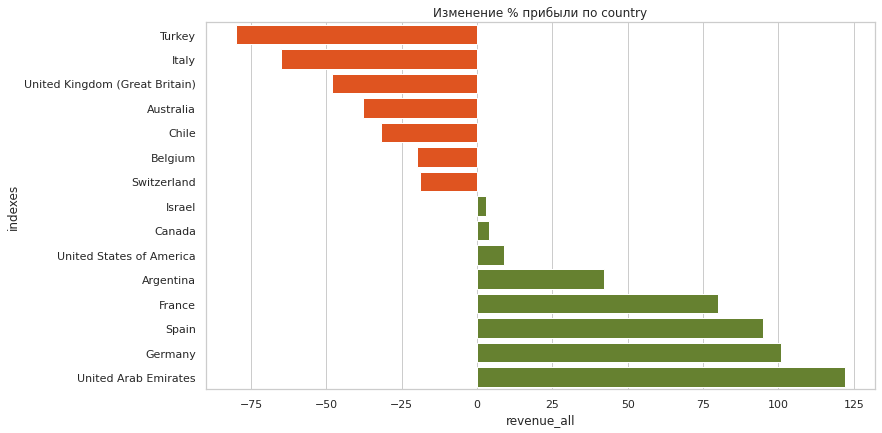

In [201]:
# список уникальных значений поиска
values = overall

# колонка сравнительных данных
column = 'country'

# получить данные
result = get_statistic(values, column).sort_values('revenue_all')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, x='revenue_all', y='indexes', palette=palette).set(title=title);

,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
0,19,0.0,-9.0,0.0,50.0,-20.0,11.0,0.0,-44.0,-17.0,-34.0,4.0,-32.0,-2.0,-31.0,-55.0,-0.0,-37.0,-45.0,-0.0
1,20,0.0,-56.0,-50.0,-64.0,-20.0,-50.0,-50.0,-60.0,34.0,-20.0,-66.0,-28.0,11.0,-23.0,7.0,61.0,60.0,40.0,7.0
2,21,0.0,14.0,0.0,33.0,0.0,17.0,33.0,90.0,-12.0,22.0,326.0,77.0,-31.0,19.0,35.0,-12.0,4.0,35.0,-12.0
3,22,0.0,-27.0,0.0,-40.0,NaN,-20.0,0.0,-73.0,NaN,NaN,NaN,-74.0,NaN,NaN,-49.0,NaN,NaN,-49.0,NaN
4,23,0.0,-62.0,-50.0,-69.0,NaN,-54.0,-33.0,-61.0,NaN,NaN,NaN,73.0,NaN,NaN,29.0,NaN,NaN,29.0,NaN
5,24,0.0,-53.0,-50.0,-45.0,-33.0,-43.0,-33.0,-43.0,28.0,-22.0,-100.0,-47.0,44.0,-24.0,-1.0,89.0,33.0,12.0,89.0
6,25,0.0,-30.0,-20.0,-20.0,NaN,-7.0,33.0,5.0,NaN,NaN,NaN,-15.0,NaN,NaN,39.0,NaN,NaN,48.0,NaN
7,26,0.0,-64.0,-67.0,-71.0,0.0,-56.0,-50.0,226.0,32.0,155.0,-70.0,53.0,69.0,148.0,1040.0,26.0,483.0,1129.0,26.0
8,27,0.0,-80.0,-100.0,-80.0,-75.0,-78.0,-100.0,-81.0,-71.0,-74.0,-100.0,-77.0,10.0,-75.0,-1.0,21.0,21.0,9.0,21.0
9,28,0.0,-37.0,-50.0,-40.0,0.0,-25.0,-50.0,1.0,-7.0,-3.0,-96.0,-36.0,55.0,-6.0,69.0,-9.0,28.0,66.0,-9.0


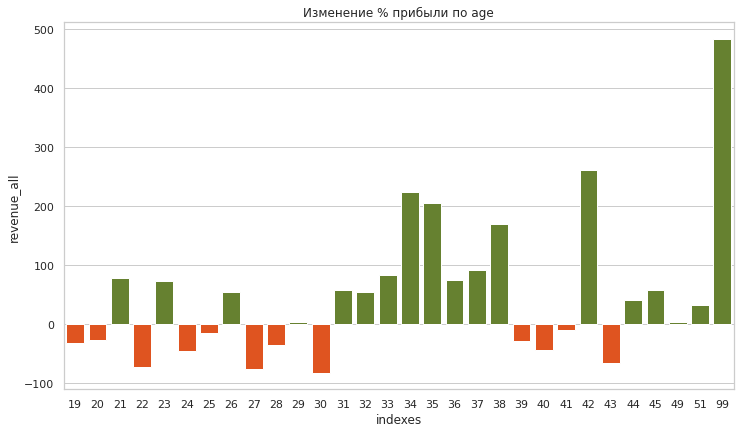

In [202]:
# список уникальных значений поиска
values = users.age.unique().tolist()

# колонка сравнительных данных
column = 'age'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, y='revenue_all', x='indexes', palette=palette).set(title=title);

,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
0,0.0,0.0,-48.0,-45.0,-73.0,-25.0,-44.0,-33.0,-68.0,-20.0,-29.0,-60.0,-31.0,4.0,-29.0,20.0,7.0,26.0,20.0,7.0
1,1.0,0.0,-9.0,0.0,-5.0,11.0,0.0,-14.0,36.0,28.0,32.0,89.0,52.0,-15.0,31.0,45.0,16.0,33.0,13.0,-4.0
2,2.0,0.0,-30.0,-33.0,-33.0,9.0,-19.0,-20.0,-11.0,23.0,5.0,-70.0,-37.0,48.0,4.0,34.0,12.0,32.0,44.0,12.0
3,3.0,0.0,-38.0,-33.0,-33.0,-43.0,-37.0,-38.0,89.0,-35.0,38.0,190.0,79.0,-23.0,38.0,184.0,13.0,118.0,155.0,13.0
4,4.0,0.0,-4.0,-9.0,-19.0,100.0,14.0,11.0,-18.0,126.0,35.0,-33.0,6.0,28.0,34.0,1.0,14.0,21.0,1.0,14.0
5,5.0,0.0,0.0,11.0,-48.0,50.0,-23.0,-33.0,-43.0,76.0,3.0,59.0,14.0,-9.0,4.0,8.0,19.0,32.0,-14.0,19.0
6,6.0,0.0,-16.0,-20.0,9.0,100.0,23.0,33.0,90.0,110.0,95.0,-68.0,23.0,64.0,100.0,85.0,5.0,66.0,135.0,5.0
7,7.0,0.0,7.0,0.0,0.0,-50.0,-29.0,-33.0,57.0,-54.0,-29.0,594.0,11.0,-34.0,-31.0,57.0,-12.0,7.0,-6.0,-12.0
8,8.0,0.0,60.0,100.0,33.0,50.0,40.0,100.0,71.0,67.0,69.0,inf,77.0,-5.0,70.0,28.0,8.0,20.0,28.0,8.0
9,9.0,0.0,-75.0,-100.0,NaN,-33.0,-75.0,-100.0,NaN,-46.0,NaN,NaN,-66.0,NaN,NaN,NaN,-16.0,NaN,NaN,-16.0


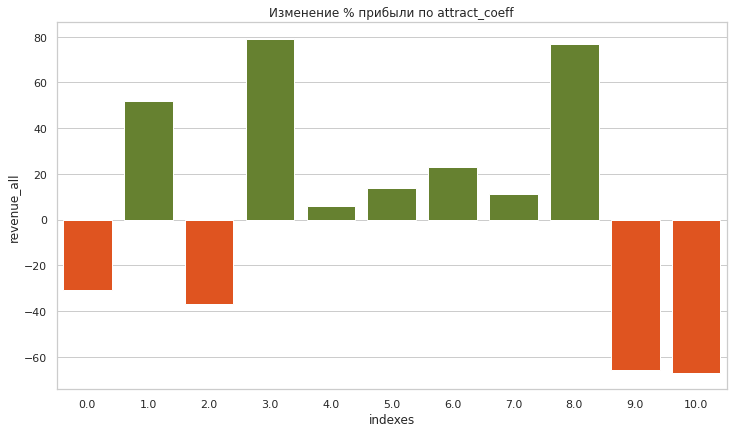

In [203]:
# список уникальных значений поиска
values = users.attract_coeff.unique().tolist()

# колонка сравнительных данных
column = 'attract_coeff'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, y='revenue_all', x='indexes', palette=palette).set(title=title);

,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
0,0,0.0,9.0,0.0,-54.0,56.0,10.0,14.0,-41.0,62.0,39.0,124.0,44.0,-3.0,36.0,34.0,4.0,26.0,34.0,4.0
1,1,0.0,-71.0,-80.0,NaN,-50.0,-71.0,-71.0,NaN,-49.0,NaN,NaN,-70.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
2,2,0.0,36.0,20.0,-60.0,300.0,30.0,20.0,-48.0,320.0,98.0,-61.0,71.0,16.0,100.0,28.0,3.0,50.0,34.0,3.0
3,3,0.0,-29.0,-33.0,20.0,-25.0,0.0,-20.0,78.0,-21.0,16.0,-89.0,-14.0,34.0,14.0,48.0,2.0,19.0,48.0,2.0
4,4,0.0,0.0,33.0,-25.0,-67.0,-43.0,-33.0,-22.0,-62.0,-45.0,190.0,32.0,-56.0,-46.0,3.0,8.0,-3.0,3.0,8.0
5,5,0.0,60.0,100.0,60.0,NaN,50.0,0.0,55.0,NaN,NaN,NaN,134.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN
6,6,0.0,-67.0,-50.0,-83.0,NaN,-57.0,-33.0,53.0,NaN,NaN,NaN,37.0,NaN,NaN,890.0,NaN,NaN,890.0,NaN
7,7,0.0,-47.0,-60.0,-71.0,-11.0,-38.0,-50.0,-79.0,1.0,-20.0,11.0,-11.0,-13.0,-24.0,-26.0,13.0,27.0,-26.0,13.0
8,8,0.0,-33.0,-50.0,-56.0,20.0,-29.0,-33.0,-68.0,72.0,-18.0,-99.0,-73.0,96.0,-18.0,-11.0,52.0,17.0,9.0,14.0
9,9,0.0,-15.0,-0.0,-22.0,-20.0,-22.0,-20.0,44.0,14.0,33.0,300.0,125.0,-43.0,35.0,86.0,47.0,72.0,86.0,47.0


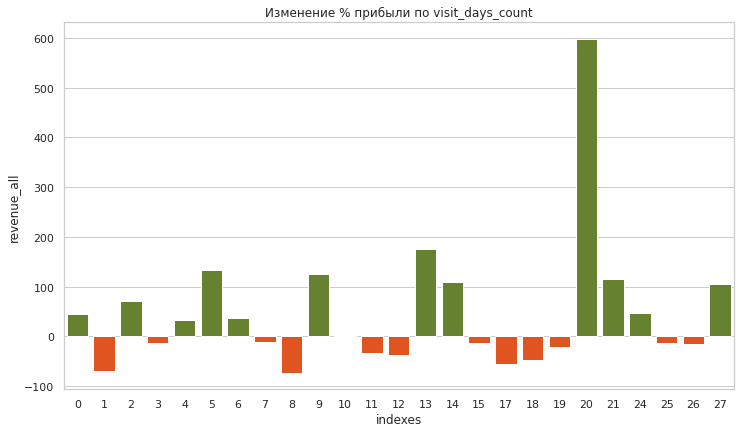

In [204]:
# список уникальных значений поиска
values = users.visit_days_count.unique().tolist()

# колонка сравнительных данных
column = 'visit_days_count'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, y='revenue_all', x='indexes', palette=palette).set(title=title);

,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
0,0,0.0,-64.0,-100.0,NaN,-20.0,-60.0,-100.0,NaN,-7.0,NaN,NaN,-37.0,NaN,NaN,NaN,12.0,NaN,NaN,12.0
1,1,0.0,-22.0,-22.0,-32.0,3.0,-20.0,-19.0,8.0,14.0,11.0,-1.0,7.0,3.0,11.0,58.0,11.0,38.0,48.0,9.0


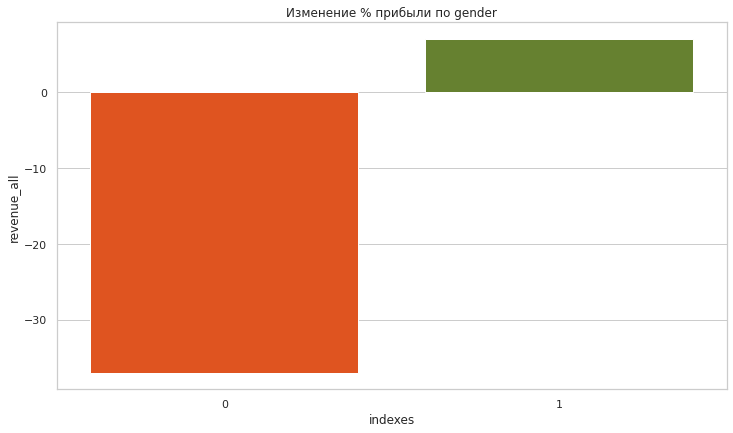

In [205]:
# список уникальных значений поиска
values = users.gender.unique().tolist()

# колонка сравнительных данных
column = 'gender'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, y='revenue_all', x='indexes', palette=palette).set(title=title);

## Вывод:
Мы рассматриваем в качестве основной метрики для изучения - показатель прибыли (revenue) из  пользователей использующих премиум-подписки в разрезах проксиметрик.

Есть страны результат которых показал как положительные результаты так и отрицательные показатели изменения прибыли.  
- положительные: United Arab Emirates +122%, Germany +101%, Spain +95%, France +80%, Argentina +42%
- отрицательные: Turkey -80%, Italy -65%, United Kingdom (Great Britain) -48%, Australia -38%

Возрастные различия: 31-38 лет платят чаще чем остальные возрастные группы.

По коэффециенту привлекательности прирост увеличился на оценках 300-800, ниже 300 имеет разброс, выше 800 снизился на 70%

Гендер 0 стал платить на 37% меньше, гендер 1 на 6% больше.

Любопытная волнообразная динамика покупки в зависимости от дня посещения после регистрации.

## Retention rate

In [206]:
# объединим данные transactions
trans = pd.concat([transactions_control_1, transactions_control_2, transactions_test])
# добавим данные users
trans = trans.merge(users, on=['uid', 'country'], how='left')

In [207]:
# добавим колонку
trans['month'] = trans.paid_at.dt.strftime('%m').astype('int32')
#отберём необходимые
select = ['trial_premium', 'premium_no_trial']
trans = trans[trans.product_type.isin(select)]

In [208]:
# список uid которые платили по несколько раз в месяц за месячную подписку
error = trans.groupby(['month', 'uid']).agg({'revenue': 'count'}).reset_index()
error_uid = error[error.revenue >1].uid.tolist()
trans[trans.uid.isin(error_uid)].sort_values(['month', 'uid'])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,...,views_count,was_premium,is_premium,total_revenue,group,visit_days_list,visit_days_count,attract_coeff,views,month
629,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:39:00,6396,147,left_sidebar_menu,premium_no_trial,39,254,...,307,1,1,34125,control_2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,3.0,5.7,2
641,891637005,Spain,2017-10-30 15:22:00,2017-02-11 13:38:00,6292,147,left_sidebar_menu,premium_no_trial,39,254,...,307,1,1,34125,control_2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,3.0,5.7,2
133,891216033,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292,0,autoreply_message,premium_no_trial,20,1000,...,2,1,1,12584,control_1,"[1, 2]",2,10.0,0.7,7
255,891216033,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292,147,autoreply_message,premium_no_trial,20,1000,...,2,1,1,12584,control_1,"[1, 2]",2,10.0,0.7,7
442,891219540,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719,0,none,premium_no_trial,24,903,...,124,1,1,9438,control_2,"[1, 2, 3, 4, 5, 6, 7, 8]",8,9.0,4.8,7
496,891219540,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719,147,none,premium_no_trial,24,903,...,124,1,1,9438,control_2,"[1, 2, 3, 4, 5, 6, 7, 8]",8,9.0,4.8,7
825,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,147,none,premium_no_trial,28,282,...,117,1,1,18434,test,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17]",14,3.0,4.8,10
890,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial,28,282,...,117,1,1,18434,test,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17]",14,3.0,4.8,10
687,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,35,319,...,219,1,1,21359,test,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16]",11,3.0,5.4,10
904,891861048,Canada,2017-10-26 02:55:00,2017-10-26 03:00:00,3588,68,none,premium_no_trial,35,319,...,219,1,1,21359,test,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16]",11,3.0,5.4,10


In [209]:
trans.paid_at.min(), trans.paid_at.max()

(Timestamp('2017-01-11 02:56:00'), Timestamp('2017-12-11 23:28:00'))

In [210]:
# определяем когорты для uid

cohort = trans.groupby('uid').agg({'month': 'min'}).reset_index().rename(columns={'month': 'cohort'})
cohort.head()

,uid,cohort
0,891068079,12
1,891071157,10
2,891077727,10
3,891092322,10
4,891112263,11


In [211]:
# определяем размеры когорт
size_cohort = cohort.groupby('cohort').agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'size_cohort'})
size_cohort.head()

,cohort,size_cohort
0,1,7
1,2,17
2,3,13
3,4,19
4,5,30


In [212]:
# определяем месяца удержания для каждого uid
group = trans.groupby(['uid', 'month']).agg({'age': 'first'}).reset_index().drop(columns=['age'])
# присваиваем когорту для каждого платежа
group = group.merge(cohort, on='uid', how='left')
group['month'] = group.month - group.cohort
group.head()

,uid,month,cohort
0,891068079,0,12
1,891071157,0,10
2,891077727,0,10
3,891092322,0,10
4,891112263,0,11


In [213]:
# собираем когорты
result = group.groupby(['cohort', 'month']).agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'users'})
result = result.merge(size_cohort, on='cohort', how='left')
result['RR'] = round(result.users / result.size_cohort, 2)
result#.head()

,cohort,month,users,size_cohort,RR
0,1,0,7,7,1.00
1,2,0,17,17,1.00
2,3,0,13,13,1.00
3,4,0,19,19,1.00
4,5,0,30,30,1.00
5,6,0,29,29,1.00
6,6,4,1,29,0.03
7,7,0,17,17,1.00
8,7,3,1,17,0.06
9,8,0,17,17,1.00


In [214]:
# построение графика когорт
def get_cohort_chart(data, index, columns, values, title, fmt):
    chart = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean') 
    plt.figure(figsize=(12, 6.75))
    plt.title(title)
    sns.heatmap(chart, annot=True, fmt=fmt, cmap='Blues');

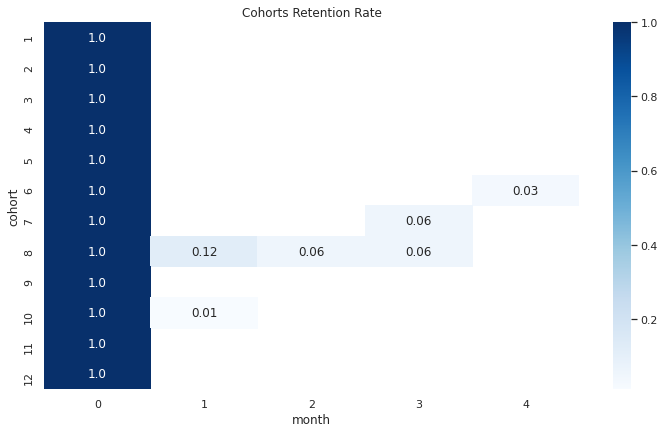

In [215]:
# построим RR
get_cohort_chart(result, 'cohort', 'month', 'RR', 'Cohorts Retention Rate', '')

### Вывод:
Удержание подписки premium низкое.  
Только 8 месяц показал удержание, 2 человека продлили на следующий месяц, 1 человек подписывался 4 месяца подряд.  
Данных анализа изменений уровня оттока по подписке - не достаточно.

## Выявление доли trial_premium в test и control группах

In [216]:
trial_premium = trans[trans.product_type == 'trial_premium']
premium_no_trial = trans[trans.product_type == 'premium_no_trial']

In [217]:
# сгруппируем пользователей
tp = trial_premium.groupby(['group', 'month']).agg({'uid': 'count'}) \
    .reset_index().rename(columns={'uid': 'users_trial'})
tp.head()

,group,month,users_trial
0,control_1,1,3
1,control_1,2,2
2,control_1,5,4
3,control_1,6,3
4,control_1,7,3


In [218]:
pnt = premium_no_trial.groupby(['group', 'month']).agg({'uid': 'count'}) \
    .reset_index().rename(columns={'uid': 'users_no_trial'})
pnt.head()

,group,month,users_no_trial
0,control_1,1,2
1,control_1,2,3
2,control_1,3,3
3,control_1,4,5
4,control_1,5,9


In [219]:
# объединим
tppnt = tp.merge(pnt, on=['group', 'month'], how='outer').fillna(0) \
    .set_index(['group', 'month']).unstack(level=0)
tppnt.columns = [ 't_control_1', 't_control_2', 't_test', 'nt_control_1', 'nt_control_2', 'nt_test']
tppnt['all_users'] = tppnt.sum(axis=1)
tppnt['all_test'] = tppnt.nt_test + tppnt.t_test
tppnt['mean_control'] = (tppnt.t_control_1 + tppnt.t_control_2 + tppnt.nt_control_1 + tppnt.nt_control_2) / 2
tppnt['trial_users'] = tppnt.t_control_1 + tppnt.t_control_2 + tppnt.t_test
tppnt['no_trial_users'] = tppnt.nt_control_1 + tppnt.nt_control_2 + tppnt.nt_test
# доля trial из всех в control
tppnt['share_trial_control'] =  round((tppnt.t_control_1 + tppnt.t_control_2) / 2 / tppnt.mean_control, 2)
# доля trial из всех в test   
tppnt['share_trial_test'] =  round(tppnt.t_test / tppnt.all_test, 2)
tppnt['test/control'] = tppnt.share_trial_test / tppnt.share_trial_control
tppnt.replace(np.inf, 0, inplace=True)
tppnt#.head()

,t_control_1,t_control_2,t_test,nt_control_1,nt_control_2,nt_test,all_users,all_test,mean_control,trial_users,no_trial_users,share_trial_control,share_trial_test,test/control
month,,,,,,,,,,,,,,
1,3.0,0.0,1.0,2.0,1.0,0.0,7.0,1.0,3.0,4.0,3.0,0.50,1.00,2.000000
2,2.0,2.0,3.0,3.0,5.0,3.0,18.0,6.0,6.0,7.0,11.0,0.33,0.50,1.515152
3,0.0,1.0,3.0,3.0,4.0,2.0,13.0,5.0,4.0,4.0,9.0,0.12,0.60,5.000000
4,0.0,0.0,2.0,5.0,7.0,5.0,19.0,7.0,6.0,2.0,17.0,0.00,0.29,0.000000
5,4.0,6.0,1.0,9.0,5.0,5.0,30.0,6.0,12.0,11.0,19.0,0.42,0.17,0.404762
6,3.0,5.0,2.0,9.0,8.0,2.0,29.0,4.0,12.5,10.0,19.0,0.32,0.50,1.562500
7,3.0,1.0,2.0,5.0,6.0,2.0,19.0,4.0,7.5,6.0,13.0,0.27,0.50,1.851852
8,3.0,3.0,1.0,6.0,3.0,1.0,17.0,2.0,7.5,7.0,10.0,0.40,0.50,1.250000
9,2.0,4.0,1.0,4.0,1.0,2.0,14.0,3.0,5.5,7.0,7.0,0.55,0.33,0.600000


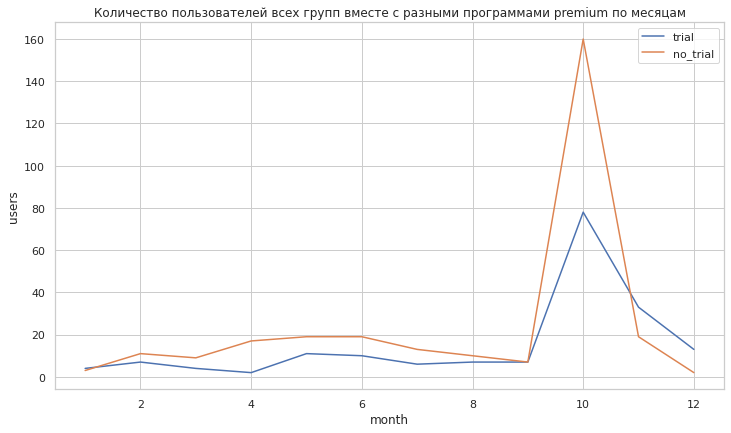

In [220]:
sns.lineplot(data=tppnt, x='month', y='trial_users')
sns.lineplot(data=tppnt, x='month', y='no_trial_users')
#sns.lineplot(data=tppnt, x='month', y='all_users')
plt.ylabel('users')
plt.title('Количество пользователей всех групп вместе с разными программами premium по месяцам')
#plt.legend(['trial', 'no_trial', 'all']);
plt.legend(['trial', 'no_trial']);

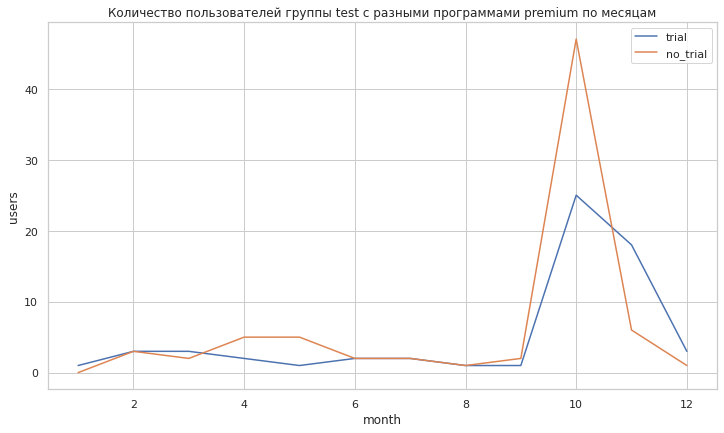

In [221]:
sns.lineplot(data=tppnt, x='month', y='t_test')
sns.lineplot(data=tppnt, x='month', y='nt_test')
#sns.lineplot(data=tppnt, x='month', y='all_test')
plt.ylabel('users')
plt.title('Количество пользователей группы test с разными программами premium по месяцам')
#plt.legend(['trial', 'no_trial', 'all']);
plt.legend(['trial', 'no_trial']);

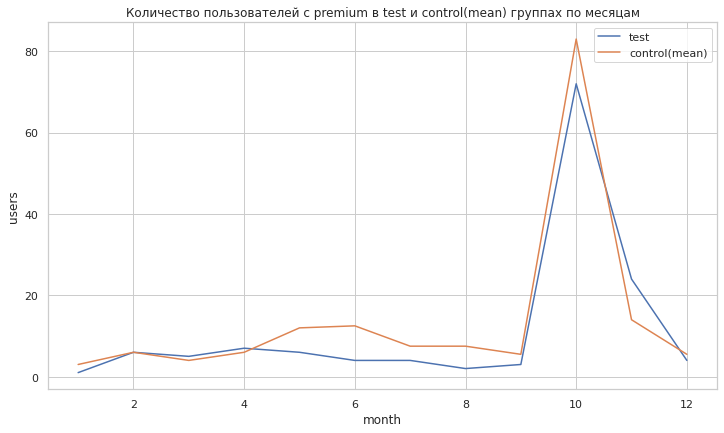

In [222]:
sns.lineplot(data=tppnt, x='month', y='all_test')
sns.lineplot(data=tppnt, x='month', y='mean_control')
plt.ylabel('users')
plt.title('Количество пользователей с premium в test и control(mean) группах по месяцам')
plt.legend(['test', 'control(mean)']);

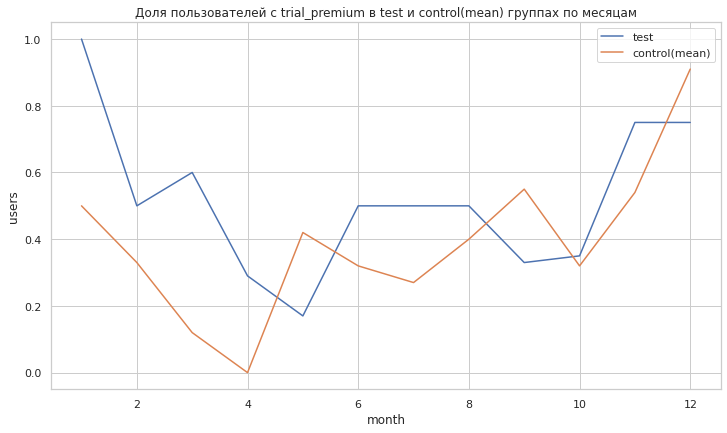

In [223]:
sns.lineplot(data=tppnt, x='month', y='share_trial_test')
sns.lineplot(data=tppnt, x='month', y='share_trial_control')
plt.ylabel('users')
plt.title('Доля пользователей с trial_premium в test и control(mean) группах по месяцам')
plt.legend(['test', 'control(mean)']);

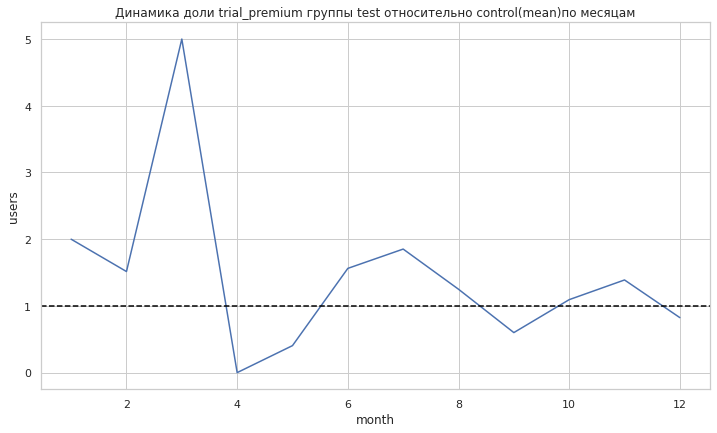

In [224]:
sns.lineplot(data=tppnt, x='month', y='test/control')
plt.ylabel('users')
plt.title('Динамика доли trial_premium группы test относительно control(mean)по месяцам')
plt.axhline(y=1, color='black', linestyle='--');

In [225]:
# доля test относительно доли control(mean), в доле trial_premium относительно всех premium
round(tppnt['test/control'].mean(), 2)

1.46

### Вывод:
Мы сравнивали средние значения control групп относительно группы test по месяцам.  
Выделили доли trial_premium и premium_no_trial для каждой из групп.  
Сравнили отношение долей у control и test групп по trial_premium.

Выяснили что в среднем за время эксперимента доля подписок на trial_premium у группы test была больше в 1.46 раза чем у группы control в относительном значении всех подписок на premium.

# Заклюение:
Эксперимент в целом можно считать успешным.  

Выяснили что в среднем за время эксперимента доля подписок на trial_premium у группы test была больше в 1.46 раза чем у группы control в относительном значении всех подписок на premium.

Увеличение стоимости подписки дало значительный прирост прибыли.   
Покаазтели premium_no_trial увеличились на 6%, trial_premium на 13%, общая прибыль на 6%

Система сплитирования сработала удовлетворительно (без учёта выбросов), есть некритичные ошибки в данных.  

Показатели retention говорят о низкой вовлечённости пользователей в программу premium, это скорее разовая подписка чем ежемесячная.

Нововведение имеет смысл вводить с учётом показателей чувствительных метрик:
- страна
- пол
- возраст
- коэффециент привлекательности
- день с момента регистрации

Сформулировать систему динамического ценообразования на основании проксиметрик.

Стоит учесть что показатель revenue отображает только общий успех компании. При принятии решений необходимо отталкиваться от ARPPU и его зависимости от CR1 а также более детального изучения показателей продуктовых метрик.